# Samsung Electronics Reviews
### Navigating Samsung Electronics: Employee Reviews (People Insights)


The dataset serves as a valuable repository of insights gleaned from employee reviews of Samsung India Electronics, a renowned Consumer Electronics & Appliances company. This dataset provides a unique window into the experiences, sentiments, and perspectives of individuals who have worked at Samsung India Electronics. It was curated by web scraping employee reviews from Ambition Box, a platform where employees share their experiences and opinions about their workplaces. The data encompasses reviews covering various topics, including work-life balance, career growth, company culture, and more.

In this project, I leveraged this dataset for sentiment analysis. I employed various machine learning models, including Decision Tree, Random Forest, Support Vector Machine, and XGBoost, with the aim of predicting the key factors influencing positive, neutral, or negative sentiments in the given reviews. Through this analysis, my goal is to delve into the essence of employee reviews and identify key elements that can impact their perceptions of the work experience at the company.

In [1]:
# Import the necessary libraries

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import random
import shap

from tqdm import tqdm
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download("vader_lexicon")
from bs4 import BeautifulSoup
from nltk.tag import pos_tag
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import xgboost as xgb 

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

from plotly import __version__
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.subplots import make_subplots
import plotly.graph_objects as go

init_notebook_mode(connected=True)
cf.go_offline()
cf.set_config_file(theme='space', sharing='public', offline=True)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Data Preparation

In [117]:
# Read the data using pandas

df = pd.read_csv('Samsung_India_Electronics_Employee_Reviews_from_AmbitionBox.csv')
df.head()

,Title,Place,Job_type,Department,Date,Overall_rating,work_life_balance,skill_development,salary_and_benefits,job_security,career_growth,work_satisfaction,Likes,Dislikes
0,Professional Logistics,Chennai,Full Time,SCM & Logistics Department,5 Sep 2023,3.0,3.0,1.0,3.0,3.0,2.0,2.0,Company provide free of cost transportation\nG...,Montonous work\nManager don't assign responsib...
1,Supervisor Instructor,Noida,Full Time,Production & Manufacturing Department,1 Sep 2023,5.0,5.0,5.0,5.0,5.0,5.0,5.0,Samsung India electronics company bhut acchi h...,Koi bhi problem nhi h company ki \nSab kuchh a...
2,Quality Inspector,Noida,Full Time,Quality Assurance and Testing Department,3 Aug 2023,4.0,4.0,4.0,4.0,4.0,4.0,4.0,Everything in Samsung India Pvt Ltd is done in...,Samsung private limited I eat discipline with ...
3,Lead Engineer,Noida,Full Time,Software Development Department,6 Aug 2023,4.0,3.0,4.0,5.0,5.0,4.0,3.0,There is a lot of scope to learn.,The rating system is not transparent. Maintain...
4,Zonal Sales Manager,Chennai,Full Time,Retail & B2C Sales Department,1 Aug 2023,4.0,2.0,3.0,3.0,3.0,3.0,4.0,Wonderful data and tracking mechanism. Innovat...,At times we don't accept the market reality


Columns Additional Information:

* Title: The job title or role of the employee providing the review.
* Place: The geographical location or city where the employee works.
* Job Type: The employment status of the reviewer (e.g., Full Time).
* Department: The specific department or functional area within the organization.
* Date: The date when the review was submitted.
* Overall Rating: A numerical rating given by the employee for their overall job satisfaction.
* Work Life Balance: Rating indicating the work-life balance experienced by the employee.
* Skill Development: Rating reflecting the opportunities for skill enhancement and growth.
* Salary and Benefits: Rating assessing the satisfaction with compensation and benefits.
* Job Security: Rating expressing the employee's sense of job security.
* Career Growth: Rating indicating the perceived career advancement opportunities.
* Work Satisfaction: Rating showcasing the employee's contentment with their work.
* Likes: Positive aspects and pros highlighted by the employee in their review.
* Dislikes: Negative aspects and cons mentioned by the employee in their review.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1211 entries, 0 to 1210
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Title                1125 non-null   object 
 1   Place                1057 non-null   object 
 2   Job_type             373 non-null    object 
 3   Department           946 non-null    object 
 4   Date                 1125 non-null   object 
 5   Overall_rating       1123 non-null   float64
 6   work_life_balance    1210 non-null   float64
 7   skill_development    1210 non-null   float64
 8   salary_and_benefits  1209 non-null   float64
 9   job_security         1208 non-null   float64
 10  career_growth        1207 non-null   float64
 11  work_satisfaction    1205 non-null   float64
 12  Likes                1004 non-null   object 
 13  Dislikes             959 non-null    object 
dtypes: float64(7), object(7)
memory usage: 132.6+ KB


In [118]:
# Combine 'Likes' and 'Dislikes' columns into a new 'review' column
df['review'] = df['Likes'].astype(str) + ' ' + df['Dislikes'].astype(str)
df.head()

,Title,Place,Job_type,Department,Date,Overall_rating,work_life_balance,skill_development,salary_and_benefits,job_security,career_growth,work_satisfaction,Likes,Dislikes,review
0,Professional Logistics,Chennai,Full Time,SCM & Logistics Department,5 Sep 2023,3.0,3.0,1.0,3.0,3.0,2.0,2.0,Company provide free of cost transportation\nG...,Montonous work\nManager don't assign responsib...,Company provide free of cost transportation\nG...
1,Supervisor Instructor,Noida,Full Time,Production & Manufacturing Department,1 Sep 2023,5.0,5.0,5.0,5.0,5.0,5.0,5.0,Samsung India electronics company bhut acchi h...,Koi bhi problem nhi h company ki \nSab kuchh a...,Samsung India electronics company bhut acchi h...
2,Quality Inspector,Noida,Full Time,Quality Assurance and Testing Department,3 Aug 2023,4.0,4.0,4.0,4.0,4.0,4.0,4.0,Everything in Samsung India Pvt Ltd is done in...,Samsung private limited I eat discipline with ...,Everything in Samsung India Pvt Ltd is done in...
3,Lead Engineer,Noida,Full Time,Software Development Department,6 Aug 2023,4.0,3.0,4.0,5.0,5.0,4.0,3.0,There is a lot of scope to learn.,The rating system is not transparent. Maintain...,There is a lot of scope to learn. The rating s...
4,Zonal Sales Manager,Chennai,Full Time,Retail & B2C Sales Department,1 Aug 2023,4.0,2.0,3.0,3.0,3.0,3.0,4.0,Wonderful data and tracking mechanism. Innovat...,At times we don't accept the market reality,Wonderful data and tracking mechanism. Innovat...


In [119]:
# Replaces contracted words in a given phrase with their expanded forms
def decontracted(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

nltk.download('stopwords')
eng_stopwords = set(stopwords.words('english'))

# Performs various text cleaning operations on the 'review' column of the DataFrame. 
# This includes removing URLs, HTML tags, contracted words, non-alphabetic characters, and stop words
def cleaning(data):
  preprocessed_reviews = []
  for sentance in tqdm(df['review'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in eng_stopwords) 
    preprocessed_reviews.append(sentance.strip())
  df['review']=preprocessed_reviews
  return data

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [120]:
df_clean_review = cleaning(df)

100%|████████████████████████████████████████████████████████████████████████████| 1211/1211 [00:01<00:00, 1004.03it/s]


In [7]:
pd.set_option('display.max_colwidth', None)
print(df_clean_review['review'].iloc[0])
pd.reset_option('display.max_colwidth')

company provide free cost transportation good medical insurance policies including parents montonous work manager assign responsibility others team culture depends korean e expat learning less ppl top level years new ideas r welcomed


In [121]:
# Perform sentiment analysis using SentimentIntensityAnalyzer
sentiment = SentimentIntensityAnalyzer()

# Calculate positive, negative, neutral, and compound scores for each review
df_clean_review["positive"] = [sentiment.polarity_scores(i)["pos"] for i in df_clean_review["review"]]
df_clean_review["negative"] = [sentiment.polarity_scores(i)["neg"] for i in df_clean_review["review"]]
df_clean_review["neutral"] = [sentiment.polarity_scores(i)["neu"] for i in df_clean_review["review"]]
df_clean_review['compound'] = [sentiment.polarity_scores(i)["compound"] for i in df_clean_review["review"]]
df_clean_review.head()

,Title,Place,Job_type,Department,Date,Overall_rating,work_life_balance,skill_development,salary_and_benefits,job_security,career_growth,work_satisfaction,Likes,Dislikes,review,positive,negative,neutral,compound
0,Professional Logistics,Chennai,Full Time,SCM & Logistics Department,5 Sep 2023,3.0,3.0,1.0,3.0,3.0,2.0,2.0,Company provide free of cost transportation\nG...,Montonous work\nManager don't assign responsib...,company provide free cost transportation good ...,0.273,0.000,0.727,0.8451
1,Supervisor Instructor,Noida,Full Time,Production & Manufacturing Department,1 Sep 2023,5.0,5.0,5.0,5.0,5.0,5.0,5.0,Samsung India electronics company bhut acchi h...,Koi bhi problem nhi h company ki \nSab kuchh a...,samsung india electronics company bhut acchi h...,0.000,0.114,0.886,-0.4019
2,Quality Inspector,Noida,Full Time,Quality Assurance and Testing Department,3 Aug 2023,4.0,4.0,4.0,4.0,4.0,4.0,4.0,Everything in Samsung India Pvt Ltd is done in...,Samsung private limited I eat discipline with ...,everything samsung india pvt ltd done good qua...,0.223,0.162,0.615,0.3818
3,Lead Engineer,Noida,Full Time,Software Development Department,6 Aug 2023,4.0,3.0,4.0,5.0,5.0,4.0,3.0,There is a lot of scope to learn.,The rating system is not transparent. Maintain...,lot scope learn rating system transparent main...,0.182,0.123,0.695,0.2732
4,Zonal Sales Manager,Chennai,Full Time,Retail & B2C Sales Department,1 Aug 2023,4.0,2.0,3.0,3.0,3.0,3.0,4.0,Wonderful data and tracking mechanism. Innovat...,At times we don't accept the market reality,wonderful data tracking mechanism innovation b...,0.686,0.000,0.314,0.9201


In [122]:
# Define a function to categorize sentiment based on compound score
def get_sentiment(score):
    return 'positive' if score >= 0.05 else ('negative' if score <= -0.05 else 'neutral')

df_clean_review['sentiment'] = df_clean_review['compound'].apply(get_sentiment)
df_clean_review.head()

,Title,Place,Job_type,Department,Date,Overall_rating,work_life_balance,skill_development,salary_and_benefits,job_security,career_growth,work_satisfaction,Likes,Dislikes,review,positive,negative,neutral,compound,sentiment
0,Professional Logistics,Chennai,Full Time,SCM & Logistics Department,5 Sep 2023,3.0,3.0,1.0,3.0,3.0,2.0,2.0,Company provide free of cost transportation\nG...,Montonous work\nManager don't assign responsib...,company provide free cost transportation good ...,0.273,0.000,0.727,0.8451,positive
1,Supervisor Instructor,Noida,Full Time,Production & Manufacturing Department,1 Sep 2023,5.0,5.0,5.0,5.0,5.0,5.0,5.0,Samsung India electronics company bhut acchi h...,Koi bhi problem nhi h company ki \nSab kuchh a...,samsung india electronics company bhut acchi h...,0.000,0.114,0.886,-0.4019,negative
2,Quality Inspector,Noida,Full Time,Quality Assurance and Testing Department,3 Aug 2023,4.0,4.0,4.0,4.0,4.0,4.0,4.0,Everything in Samsung India Pvt Ltd is done in...,Samsung private limited I eat discipline with ...,everything samsung india pvt ltd done good qua...,0.223,0.162,0.615,0.3818,positive
3,Lead Engineer,Noida,Full Time,Software Development Department,6 Aug 2023,4.0,3.0,4.0,5.0,5.0,4.0,3.0,There is a lot of scope to learn.,The rating system is not transparent. Maintain...,lot scope learn rating system transparent main...,0.182,0.123,0.695,0.2732,positive
4,Zonal Sales Manager,Chennai,Full Time,Retail & B2C Sales Department,1 Aug 2023,4.0,2.0,3.0,3.0,3.0,3.0,4.0,Wonderful data and tracking mechanism. Innovat...,At times we don't accept the market reality,wonderful data tracking mechanism innovation b...,0.686,0.000,0.314,0.9201,positive


In [10]:
df_clean_review["sentiment"].value_counts()

positive    749
neutral     369
negative     93
Name: sentiment, dtype: int64

In [123]:
# drop unused columns
df_clean_review.drop(columns = ['Likes', 'Dislikes', 'positive', 'negative', 'neutral', 'compound'], inplace=True)

In [12]:
df_clean_review.select_dtypes(include='object').nunique()

Title         612
Place         304
Job_type        4
Department    224
Date          491
review        983
sentiment       3
dtype: int64

In [13]:
df_clean_review.Job_type.unique()

array(['Full Time', 'Contractual', 'Part Time', 'Intern', nan],
      dtype=object)

In [14]:
df_clean_review[df_clean_review['Job_type'].isnull()].head()

,Title,Place,Job_type,Department,Date,Overall_rating,work_life_balance,skill_development,salary_and_benefits,job_security,career_growth,work_satisfaction,review,sentiment
89,Apprentice Training (working remotely),NaN,NaN,"Operations, Maintenance & Support Department",1 May 2023,5.0,4.0,5.0,5.0,5.0,5.0,5.0,best company samsung dislikes,positive
129,Area Business Manager,"Nagpur, Maharashtra",NaN,BD / Pre Sales Department,4 Nov 2022,4.0,3.0,4.0,5.0,4.0,4.0,3.0,company pay master pressure work u take work p...,negative
139,Production Supervisor,Chennai,NaN,Production Department,2 Mar 2023,5.0,5.0,5.0,3.0,5.0,4.0,3.0,none nan,neutral
157,Production Lead,"Chennai, Tamil Nadu",NaN,"Operations, Maintenance & Support Department",8 Nov 2022,3.0,3.0,4.0,4.0,4.0,4.0,3.0,suprising gifts working structured every shift...,neutral
158,Customer Experience Executive,Gurgaon,NaN,Sales Support & Operations Department,4 Oct 2022,5.0,5.0,4.0,4.0,5.0,5.0,4.0,working environment work life balanced none,neutral


In [124]:
# # Fill missing values in the 'Job_type' column with the value 'Other'
df_clean_review['Job_type'].fillna('Other', inplace=True)

In [16]:
df_clean_review.Department.unique()

array(['SCM & Logistics Department',
       'Production & Manufacturing Department',
       'Quality Assurance and Testing Department',
       'Software Development Department', 'Retail & B2C Sales Department',
       'Sales Department', 'Enterprise & B2B Sales Department',
       'Service Delivery Department', 'Administration Department',
       'HR Operations Department', 'Marketing Department',
       'Operations, Maintenance & Support Department',
       'Operations Department', 'Engineering Department',
       'Other Department', 'Sales Support & Operations Department',
       'Operations Support Department',
       'After Sales Service & Repair Department',
       'Engineering & Manufacturing Department',
       'Procurement & Purchase Department', 'Telecom Department',
       'Accounting & Taxation Department', 'Customer Success Department',
       'General Insurance Department',
       'Warehouse Manpower supervisor  Department', nan,
       'Back Office Department', 'Quality D

In [17]:
df_clean_review['Department'].value_counts().head(20)

Retail & B2C Sales Department                   77
Software Development Department                 72
Enterprise & B2B Sales Department               56
Operations, Maintenance & Support Department    46
BD / Pre Sales Department                       46
Production & Manufacturing Department           27
Marketing Department                            26
Engineering Department                          21
SCM & Logistics Department                      20
Operations Department                           19
Accounting & Taxation Department                19
Quality Assurance and Testing Department        18
Procurement & Purchase Department               18
Sales Support & Operations Department           17
Sales Department                                17
Administration Department                       15
Voice / Blended Department                      14
Technology / IT Department                      14
Engineering & Manufacturing Department          14
Telecom Department             

In [125]:
# Function to categorize departments into broader segments
def group_department(department):
    if pd.isna(department):
        return 'Other'
    
    if any(keyword in department for keyword in ['Sales', 'Marketing', 'Retail', 'B2C', 'BD / Pre Sales', 'Enterprise']):
        return 'Sales and Marketing'
    elif any(keyword in department for keyword in ['Production', 'Manufacturing', 'Engineering', 'Mobile plant']):
        return 'Production and Manufacturing'
    elif any(keyword in department for keyword in ['Logistics', 'Operations', 'Supply Chain', 'Warehouse', 'Procurement', 'Shipping']):
        return 'Operation and Logistic'
    elif any(keyword in department for keyword in ['Quality', 'Quality Assurance', 'Testing', 'Quality Control']):
        return 'Quality Assurance and Testing'
    elif any(keyword in department for keyword in ['Corporate Communication', 'Employee Relations', 'Administration', 'Admin', 'Facility', 'Front Office', 'Back Office', 'Security Officer', 'Customer Service']):
        return 'Administration and Support'
    elif any(keyword in department for keyword in ['IT Consulting', 'Technology / IT', 'IT Infrastructure', 'IT Support', 'IT Network', 'Software Development', 'Database', 'DevOps', 'Hardware', 'Network', 'Telecom']):
        return 'Technology'
    else:
        return 'Other'

# Apply the function to create a new column 'department_segment'
df_clean_review['department_segment'] = df_clean_review['Department'].apply(group_department)

In [19]:
df_clean_review.Place.unique()

array(['Chennai', 'Noida', 'Faridabad, Haryana',
       'Bengaluru/Bangalore, Karnataka', 'Hyderabad/Secunderabad',
       'Guwahati, Assam', 'Gurgaon/Gurugram, Haryana', 'Gurgaon/Gurugram',
       'Mumbai', 'Bangalore Rural, Karnataka', 'Chennai, Tamil Nadu',
       'Patna, Bihar', nan, 'Lucknow, Uttar Pradesh',
       'Tirupati, Andhra Pradesh', 'Varanasi, Uttar Pradesh',
       'Jaipur, Rajasthan', 'Mumbai, Maharashtra',
       'Puranpur, Uttar Pradesh', 'Ludhiana, (Punjab)',
       'Noida, Uttar Pradesh', 'Faridkot, Punjab',
       'Mysuru/Mysore, Karnataka', 'Nizamabad, Telangana',
       'Sriperumbudur, Tamil Nadu', 'Jaipur', 'Jammu, Jammu & Kashmir',
       'Kolkata, West Bengal', 'Bhagalpur, Bihar',
       'Hyderabad/Secunderabad, Telangana', 'Raipur, Chhattisgarh',
       'Bhubaneswar, Odisha', 'Ahmedabad, Gujarat',
       'Kancheepuram, Tamil Nadu', 'Chhutmalpur',
       'Maldah/Malda, West Bengal', 'Bhilwara Rajasthan',
       'Agra, Uttar Pradesh', 'Katwa, West Bengal',
   

In [126]:
# Function to categorize places into broader segments
def group_place(place):
    if pd.isna(place):
        return 'Other'
    
    if any(keyword in place for keyword in ['Jammu & Kashmir', 'Haryana', 'Himachal Pradesh', 'Punjab', 'Rajasthan', 'Delhi', 'Chandigarh', 'Ladakh', 'Srinagar', 'Leh', 'Jammu', 'Jaipur', 'Shimla', 'Patna', 'Varanasi', 'Gurgaon', 'Gurugram', 'Ludhiana']):
        return 'Northern Zone'
    elif any(keyword in place for keyword in ['Uttar Pradesh', 'Chhattisgarh', 'Uttarkhand', 'Madhya Pradesh', 'Dehraduri', 'Lucknow', 'Bhopal', 'Raipur', 'Indore', 'Jabalpur', 'Noida']):
        return 'Central Zone'
    elif any(keyword in place for keyword in ['Bihar', 'Jharkhand', 'Odhisa', 'Sikkim', 'West Bengal', 'Patna', 'Ranchi', 'Kolkata', 'Gangtok', 'Bhubaneswar', 'Bhubaneswar', 'Guwahati', 'Bhubaneswar', 'Ranchi']):
        return 'Eastern Zone'
    elif any(keyword in place for keyword in ['Goa', 'Gujarat', 'Maharashtra', 'Daman & Diu', 'Dadra & Nagar Haveli', 'Ghandinagar', 'Daman', 'Mumbai', 'Panaji', 'Ahmedabad', 'Surat']):
        return 'Western Zone'
    elif any(keyword in place for keyword in ['Telangana', 'Hyderabad', 'Amaravati', 'Yanam', 'Andhra Pradesh', 'Karnataka', 'Bengaluru', 'Mahe', 'Tamil Nadu', 'Kerala', 'Karaikal', 'Chennai' 'Vijayawada', 'Tirupati']):
        return 'Southern Zone'
    else:
        return 'Other'

df_clean_review['place_segment'] = df_clean_review['Place'].apply(group_place)

In [21]:
df_clean_review['Place'].value_counts().head(20)

Noida                        194
Chennai                       86
Gurgaon                       39
Gurgaon/Gurugram              38
Mumbai                        36
Noida, Uttar Pradesh          29
Kolkata                       23
Patna                         18
Delhi NCR                     17
Greater Noida                 17
Gurgaon/Gurugram, Haryana     16
Bangalore                     13
Pune                          12
Jaipur                        11
Lucknow                       11
Indore                        11
Chennai, Tamil Nadu           11
Raipur                        10
Ahmedabad                     10
Bhubaneswar                    9
Name: Place, dtype: int64

In [127]:
df_clean_review.drop(columns = ['Title', 'Place', 'Department', 'Date', 'review'], inplace=True)
df_clean_review.head()

,Job_type,Overall_rating,work_life_balance,skill_development,salary_and_benefits,job_security,career_growth,work_satisfaction,sentiment,department_segment,place_segment
0,Full Time,3.0,3.0,1.0,3.0,3.0,2.0,2.0,positive,Operation and Logistic,Other
1,Full Time,5.0,5.0,5.0,5.0,5.0,5.0,5.0,negative,Production and Manufacturing,Central Zone
2,Full Time,4.0,4.0,4.0,4.0,4.0,4.0,4.0,positive,Quality Assurance and Testing,Central Zone
3,Full Time,4.0,3.0,4.0,5.0,5.0,4.0,3.0,positive,Technology,Central Zone
4,Full Time,4.0,2.0,3.0,3.0,3.0,3.0,4.0,positive,Sales and Marketing,Other


In [128]:
df_clean_review.rename(columns = {'Job_type':'job_type'}, inplace=True)

## Exploratory Data Analysis

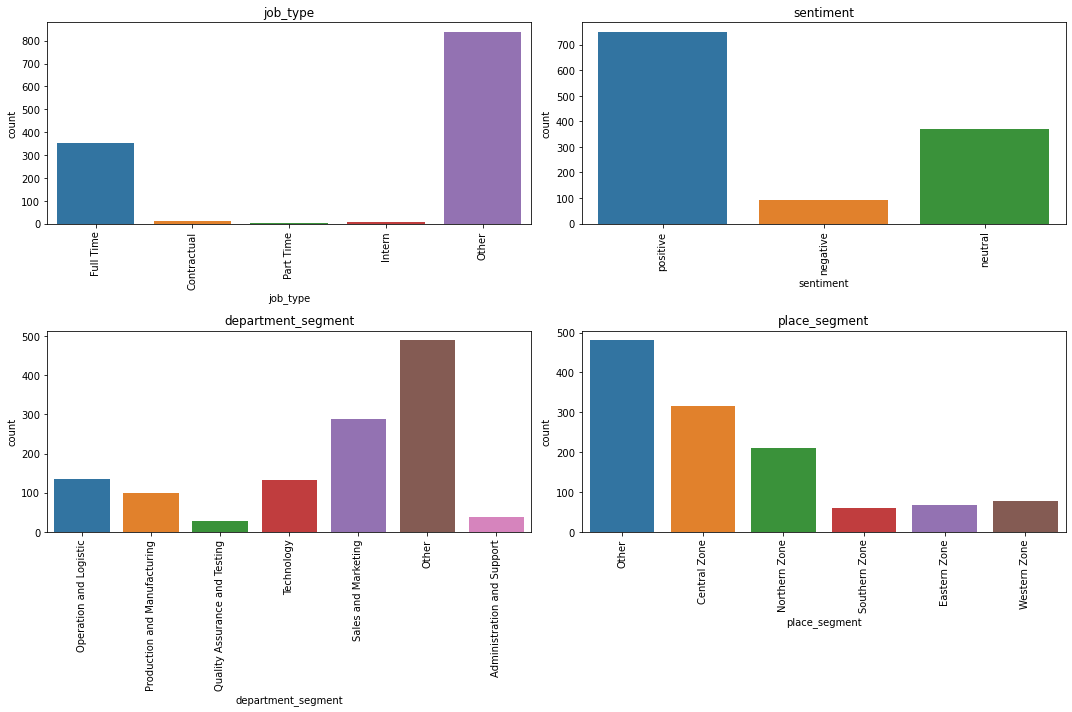

In [129]:
# Get categorical variables
cat_vars = df_clean_review.select_dtypes(include='object').columns.tolist()

# Determine subplot layout
num_cols = len(cat_vars)
num_rows = (num_cols + 1) // 2

# Create subplot
fig, axs = plt.subplots(nrows=num_rows, ncols=2, figsize=(15, 5*num_rows))

# Plot count for each categorical variable
for i, var in enumerate(cat_vars):
    top_values = df_clean_review[var].value_counts().index
    filtered_df = df_clean_review[df_clean_review[var].isin(top_values)]
    
    # Plot count using seaborn
    sns.countplot(x=var, data=filtered_df, ax=axs[i // 2, i % 2])
    
    axs[i // 2, i % 2].set_title(var)
    axs[i // 2, i % 2].set_xticklabels(axs[i // 2, i % 2].get_xticklabels(), rotation=90)

# Adjust layout
fig.tight_layout()

# Display the plot
plt.show()

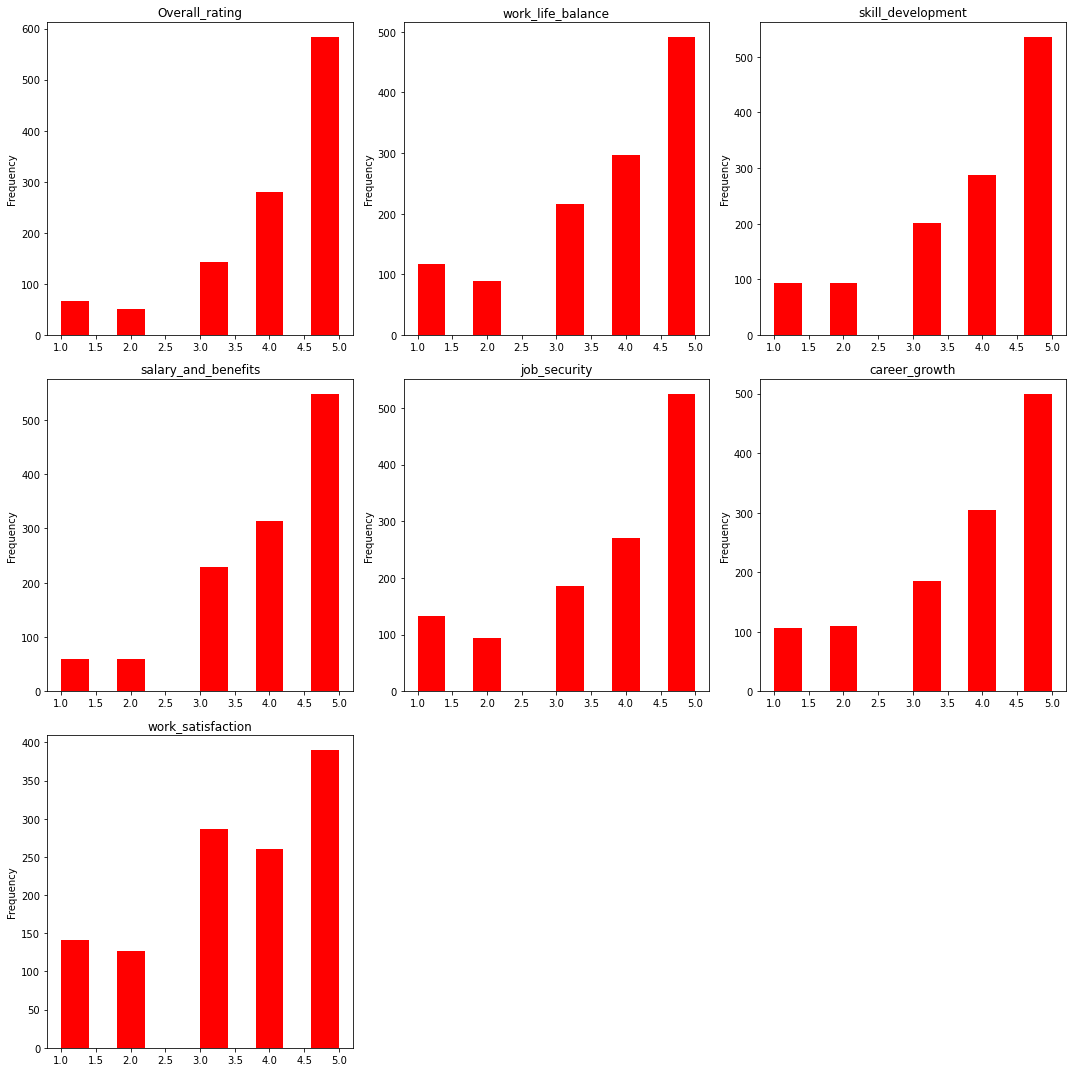

In [134]:
# Get numerical variables
num_vars = df_clean_review.select_dtypes(include=['int', 'float']).columns.tolist()

# Determine subplot layout
num_cols = len(num_vars)
num_rows = (num_cols + 2) // 3

# Create subplot
fig, axs = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 5*num_rows))
axs = axs.flatten()

# Plot histogram for each numerical variable
for i, var in enumerate(num_vars):
    df_clean_review[var].plot.hist(ax=axs[i], color='red')
    axs[i].set_title(var)

if num_cols < len(axs):
    for i in range(num_cols, len(axs)):
        fig.delaxes(axs[i])
        
# Adjust layout
fig.tight_layout()

# Display the plot
plt.show()

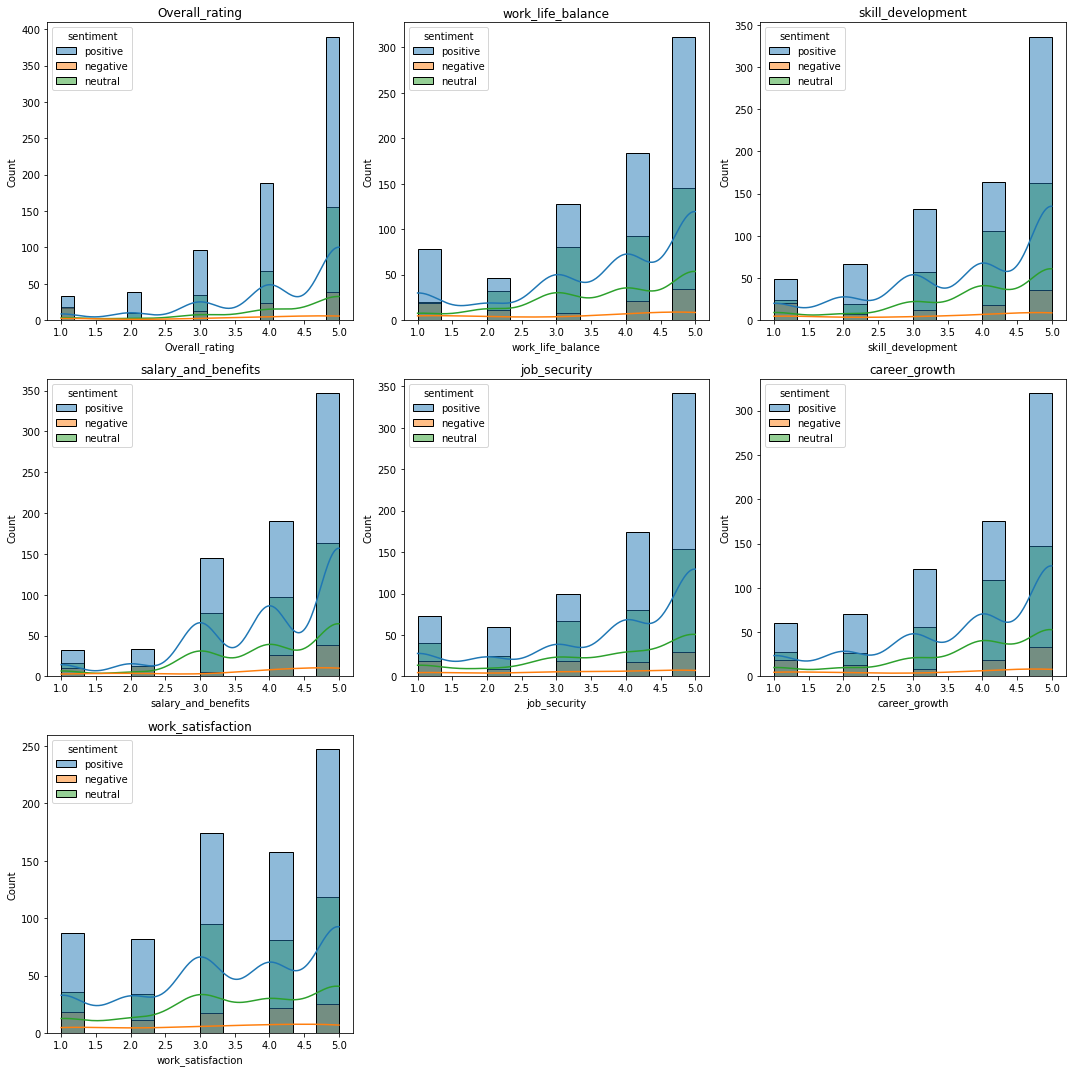

In [26]:
# Get numerical variable
num_vars = df_clean_review.select_dtypes(include=['int', 'float']).columns.tolist()

# Determine subplot layout
num_cols = len(num_vars)
num_rows = (num_cols + 2) // 3

# Create subplot
fig, axs = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 5*num_rows))
axs = axs.flatten()

# Plot histogram for each numerical variable with sentiment color-coding
for i, var in enumerate(num_vars):
    sns.histplot(data=df_clean_review, x=var, hue='sentiment', kde=True, ax=axs[i])
    axs[i].set_title(var)

# Remove any extra empty subplots if needed    
if num_cols < len(axs):
    for i in range(num_cols, len(axs)):
        fig.delaxes(axs[i])

# Adjust layout        
fig.tight_layout()

# Show the plot
plt.show()

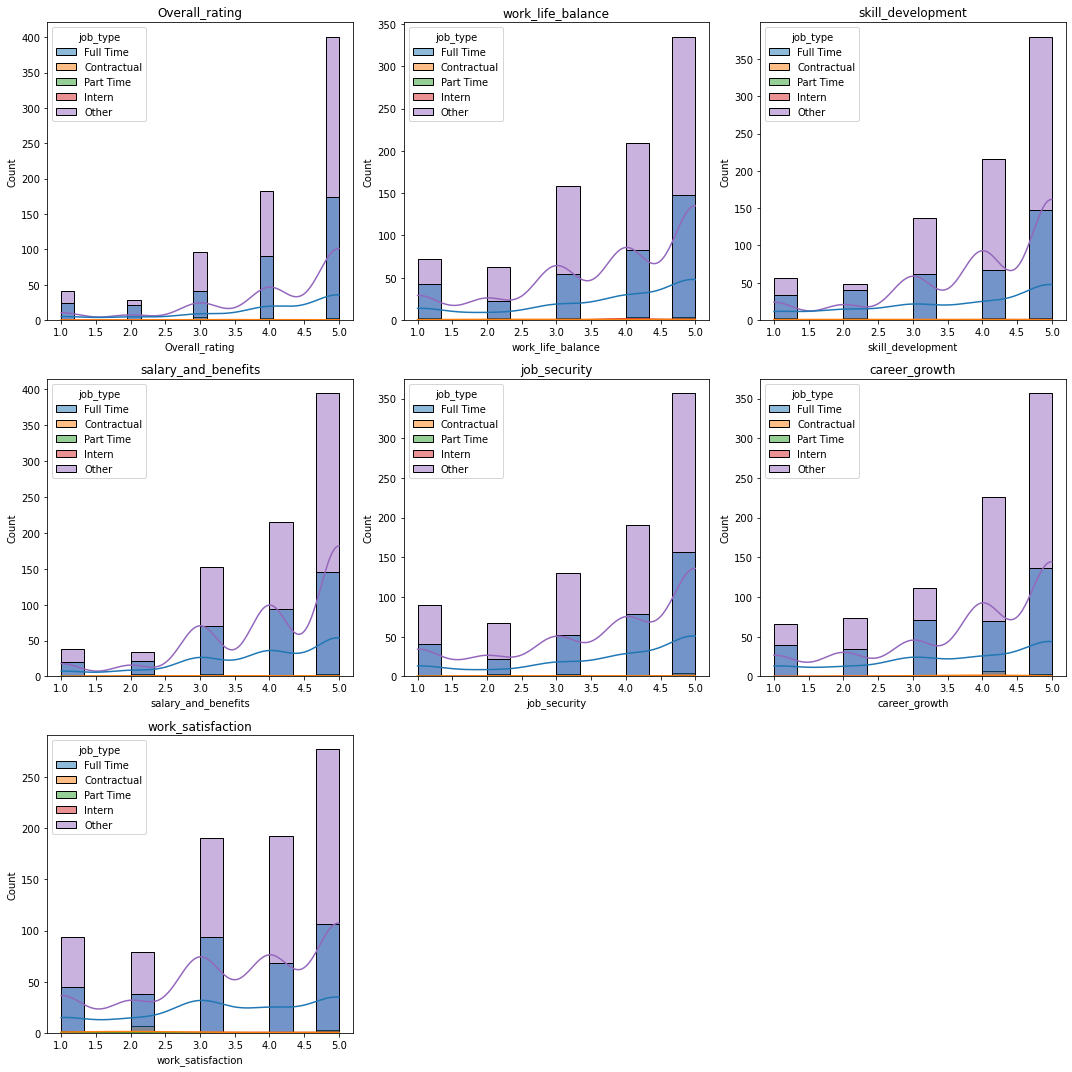

In [27]:
# Get numerical variables
num_vars = df_clean_review.select_dtypes(include=['int', 'float']).columns.tolist()

# Determine subplot layout
num_cols = len(num_vars)
num_rows = (num_cols + 2) // 3

# Create subplot
fig, axs = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 5*num_rows))
axs = axs.flatten()

# Plot histogram for each numerical variable with job_type color-coding
for i, var in enumerate(num_vars):
    sns.histplot(data=df_clean_review, x=var, hue='job_type', kde=True, ax=axs[i])
    axs[i].set_title(var)

# Remove any extra empty subplots if needed    
if num_cols < len(axs):
    for i in range(num_cols, len(axs)):
        fig.delaxes(axs[i])

# Adjust layout        
fig.tight_layout()

# Show the plot
plt.show()

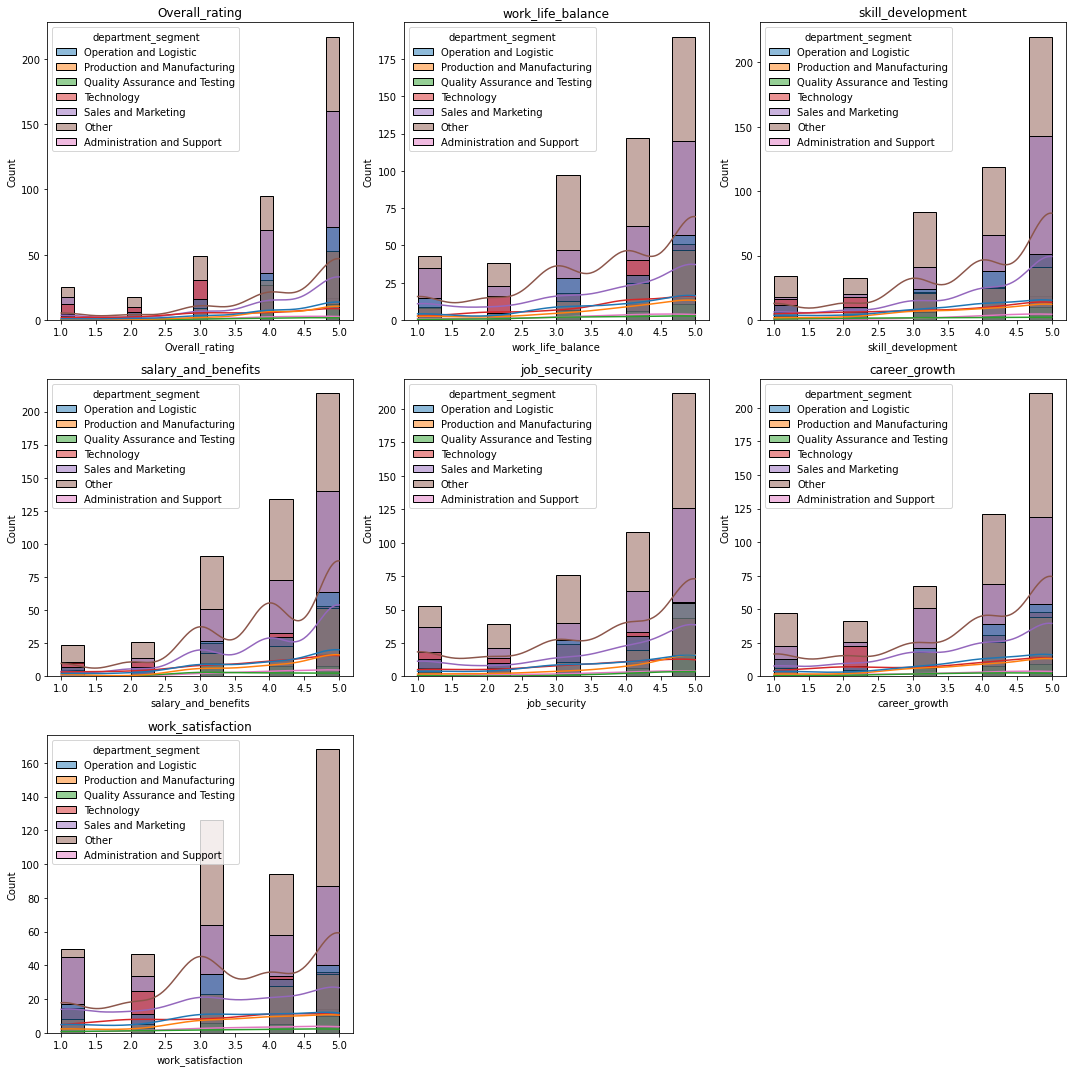

In [28]:
# Get numerical variables 
num_vars = df_clean_review.select_dtypes(include=['int', 'float']).columns.tolist()

# Determine subplot layout
num_cols = len(num_vars)
num_rows = (num_cols + 2) // 3

# Cretae subplot
fig, axs = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 5*num_rows))
axs = axs.flatten()

# Plot histogram for each numerical variable with department_segment color-coding
for i, var in enumerate(num_vars):
    sns.histplot(data=df_clean_review, x=var, hue='department_segment', kde=True, ax=axs[i])
    axs[i].set_title(var)

# Remove any extra empty subplots if needed    
if num_cols < len(axs):
    for i in range(num_cols, len(axs)):
        fig.delaxes(axs[i])

# Adjust layout         
fig.tight_layout()

# Show the plot
plt.show()

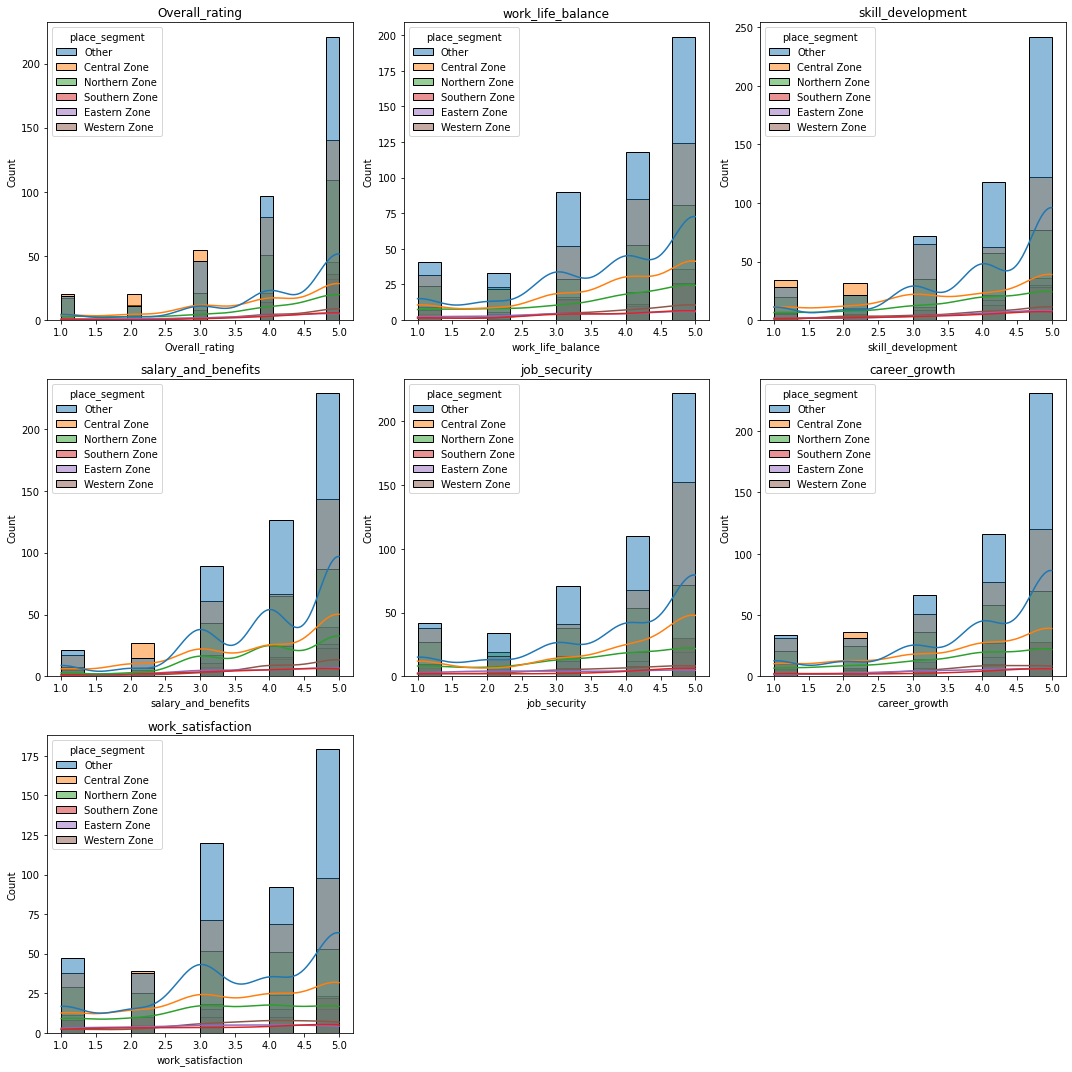

In [29]:
# Get numerical variables
num_vars = df_clean_review.select_dtypes(include=['int', 'float']).columns.tolist()

# Determine subplot layout
num_cols = len(num_vars)
num_rows = (num_cols + 2) // 3

# Create subplot
fig, axs = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 5*num_rows))
axs = axs.flatten()

# Plot histogram for each numerical variable with place_segment color-coding
for i, var in enumerate(num_vars):
    sns.histplot(data=df_clean_review, x=var, hue='place_segment', kde=True, ax=axs[i])
    axs[i].set_title(var)
    
# Remove any extra empty subplots if needed    
if num_cols < len(axs):
    for i in range(num_cols, len(axs)):
        fig.delaxes(axs[i])

# Adjust layout        
fig.tight_layout()

# Show the plot
plt.show()

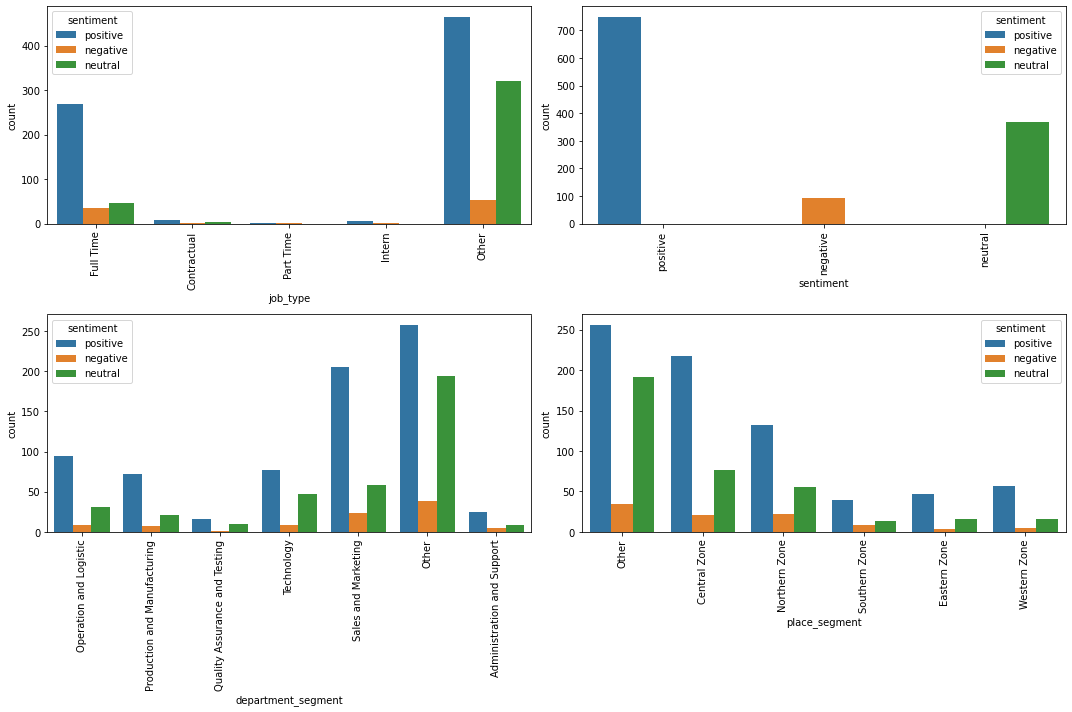

In [30]:
# Get categorical variables
cat_vars = df_clean_review.select_dtypes(include=['object']).columns.tolist()

# Determine subplot layout
num_cols = len(cat_vars)
num_rows = (num_cols + 2) // 3

# Create subplot
fig, axs = plt.subplots(nrows=num_rows, ncols=2, figsize=(15, 5*num_rows))
axs = axs.flatten()

# Plot countplot for each categorical variable with sentiment color-coding
for i, var in enumerate(cat_vars):
    # Exclude rows with NaN values in the variable
    filtered_df = df_clean_review[df_clean_review[var].notnull()]
    
    sns.countplot(x=var, hue='sentiment', data=filtered_df, ax=axs[i])
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)

# Remove any remaining blank subplots
for i in range(num_cols, len(axs)):
    fig.delaxes(axs[i])

# Adjust layout
fig.tight_layout()

# Show the plot
plt.show()

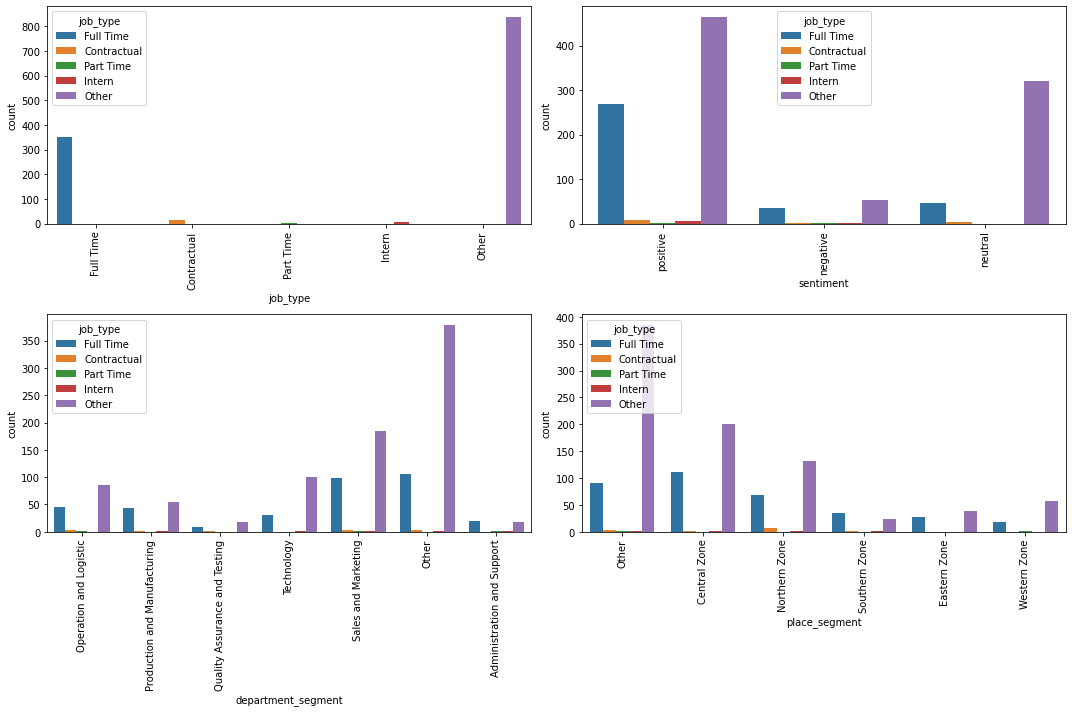

In [31]:
# Get categorical variables
cat_vars = df_clean_review.select_dtypes(include=['object']).columns.tolist()

# Determine subplot layout
num_cols = len(cat_vars)
num_rows = (num_cols + 2) // 3

# Create subplot
fig, axs = plt.subplots(nrows=num_rows, ncols=2, figsize=(15, 5*num_rows))
axs = axs.flatten()

# Plot countplot for each categorical variable with sentiment color-coding
for i, var in enumerate(cat_vars):
    # Exclude rows with NaN values in the variable
    filtered_df = df_clean_review[df_clean_review[var].notnull()]
    
    sns.countplot(x=var, hue='job_type', data=filtered_df, ax=axs[i])
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)

# Remove any remaining blank subplots
for i in range(num_cols, len(axs)):
    fig.delaxes(axs[i])

# Adjust layout
fig.tight_layout()

# Show the plot
plt.show()

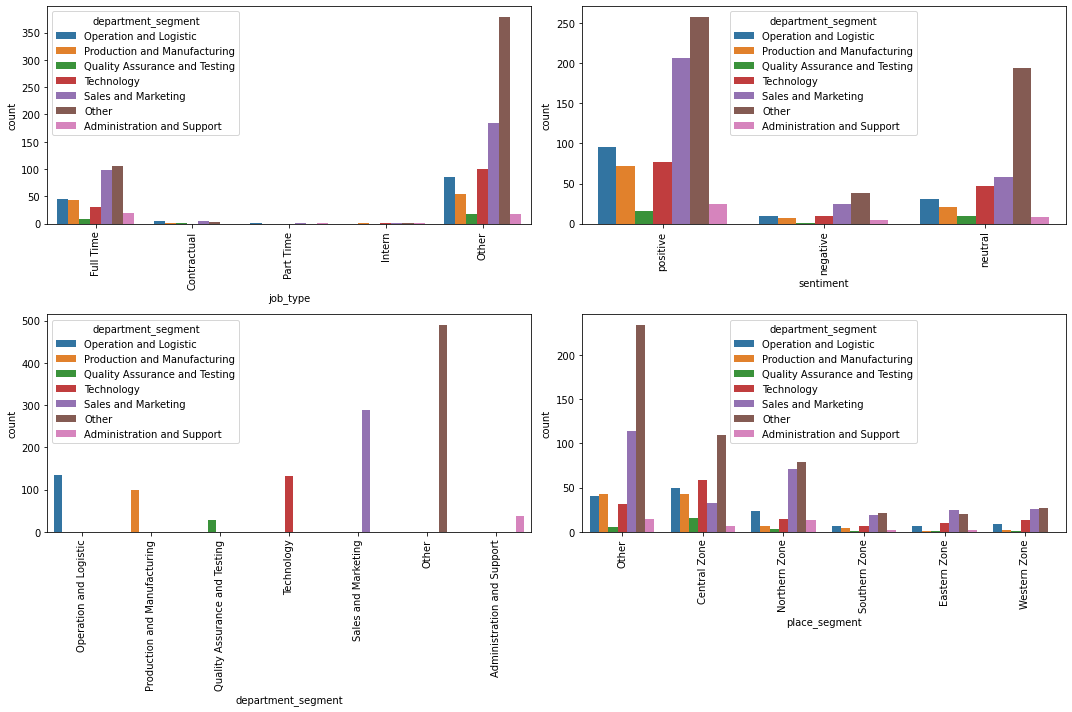

In [32]:
# Get categorical variables
cat_vars = df_clean_review.select_dtypes(include=['object']).columns.tolist()

# Determine subplot layout
num_cols = len(cat_vars)
num_rows = (num_cols + 2) // 3

# Create subplot
fig, axs = plt.subplots(nrows=num_rows, ncols=2, figsize=(15, 5*num_rows))
axs = axs.flatten()

# Plot countplot for each categorical variable with sentiment color-coding
for i, var in enumerate(cat_vars):
    # Exclude rows with NaN values in the variable
    filtered_df = df_clean_review[df_clean_review[var].notnull()]
    
    sns.countplot(x=var, hue='department_segment', data=filtered_df, ax=axs[i])
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)

# Remove any remaining blank subplots
for i in range(num_cols, len(axs)):
    fig.delaxes(axs[i])

# Adjust layout
fig.tight_layout()

# Show the plot
plt.show()

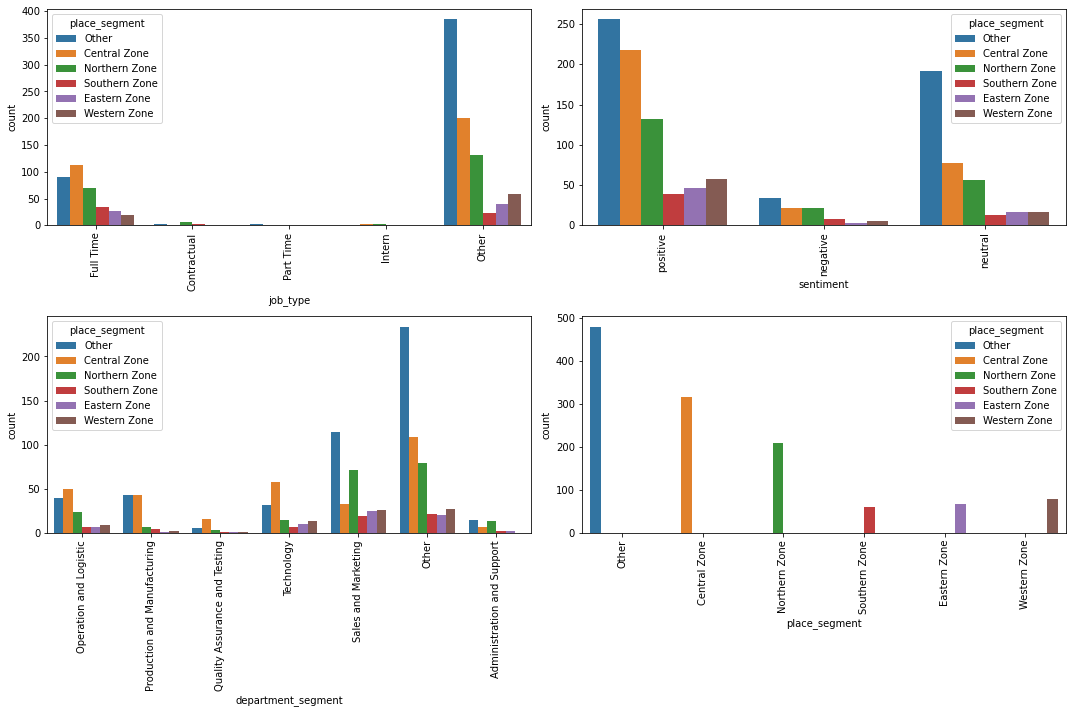

In [33]:
# Get categorical variables
cat_vars = df_clean_review.select_dtypes(include=['object']).columns.tolist()

# Determine subplot layout
num_cols = len(cat_vars)
num_rows = (num_cols + 2) // 3

# Create subplot
fig, axs = plt.subplots(nrows=num_rows, ncols=2, figsize=(15, 5*num_rows))
axs = axs.flatten()

# Plot countplot for each categorical variable with sentiment color-coding
for i, var in enumerate(cat_vars):
    # Exclude rows with NaN values in the variable
    filtered_df = df_clean_review[df_clean_review[var].notnull()]
    
    sns.countplot(x=var, hue='place_segment', data=filtered_df, ax=axs[i])
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)

# Remove any remaining blank subplots
for i in range(num_cols, len(axs)):
    fig.delaxes(axs[i])

# Adjust layout
fig.tight_layout()

# Show the plot
plt.show()

Based on exploratory data analysis above it reveals that the majority of object-type categorical attributes have the largest values labeled as 'Other.' Specifically, in the job_type attribute, 'Full Time' dominates as the second-largest value, while 'Part Time' is the smallest. A similar pattern occurs in the department_segment attribute, where 'Sales and Marketing' holds the second-largest value, and in the place_segment attribute, 'Central Zone' ranks second.

Future strategies could involve further exploration of the 'Other' category to understand its composition better. If feasible, considering the consolidation of several categories into larger groups may enhance interpretation. Additionally, focusing on increasing variation in minor values such as 'Part Time' and 'Southern Zone' might provide further insights into trends and patterns within the dataset.

For the sentiment attribute, a deeper understanding of factors influencing negative sentiment could be a focus. Delving into the analysis of this category can help identify specific aspects that may need improvement. Therefore, further actions can be taken to enhance employee experience and workplace atmosphere.

## Data Preprocessing

In [34]:
df_clean_review.head()

,job_type,Overall_rating,work_life_balance,skill_development,salary_and_benefits,job_security,career_growth,work_satisfaction,sentiment,department_segment,place_segment
0,Full Time,3.0,3.0,1.0,3.0,3.0,2.0,2.0,positive,Operation and Logistic,Other
1,Full Time,5.0,5.0,5.0,5.0,5.0,5.0,5.0,negative,Production and Manufacturing,Central Zone
2,Full Time,4.0,4.0,4.0,4.0,4.0,4.0,4.0,positive,Quality Assurance and Testing,Central Zone
3,Full Time,4.0,3.0,4.0,5.0,5.0,4.0,3.0,positive,Technology,Central Zone
4,Full Time,4.0,2.0,3.0,3.0,3.0,3.0,4.0,positive,Sales and Marketing,Other


In [35]:
# Calculate and display the percentage of missing values for each column
missing_percentages = (df_clean_review.isnull().mean() * 100).sort_values(ascending=False)
missing_values = missing_percentages[missing_percentages > 0]
print(missing_values)

Overall_rating         7.266722
work_satisfaction      0.495458
career_growth          0.330306
job_security           0.247729
salary_and_benefits    0.165153
skill_development      0.082576
work_life_balance      0.082576
dtype: float64


### Feature Engineering: Label Encoding for Object datatypes

In [36]:
for col in df_clean_review.select_dtypes(include='object').columns:
    unique_values = df_clean_review[col].unique()
    print(f"{col}: {unique_values}")

job_type: ['Full Time' 'Contractual' 'Part Time' 'Intern' 'Other']
sentiment: ['positive' 'negative' 'neutral']
department_segment: ['Operation and Logistic' 'Production and Manufacturing'
 'Quality Assurance and Testing' 'Technology' 'Sales and Marketing'
 'Other' 'Administration and Support']
place_segment: ['Other' 'Central Zone' 'Northern Zone' 'Southern Zone' 'Eastern Zone'
 'Western Zone']


In [37]:
label_encoder = LabelEncoder()

# Loop over each column in the DataFrame where dtype is 'object'
for col in df_clean_review.select_dtypes(include=['object']).columns:
    
    # Use LabelEncoder directly with apply
    df_clean_review[col] = label_encoder.fit_transform(df_clean_review[col])
    
    # Print the column name and the unique encoded values
    print(f"{col}: {df_clean_review[col].unique()}")

job_type: [1 0 4 2 3]
sentiment: [2 0 1]
department_segment: [1 3 4 6 5 2 0]
place_segment: [3 0 2 4 1 5]


### Feature Selection: Correlation Matrix with Heatmap

<AxesSubplot:>

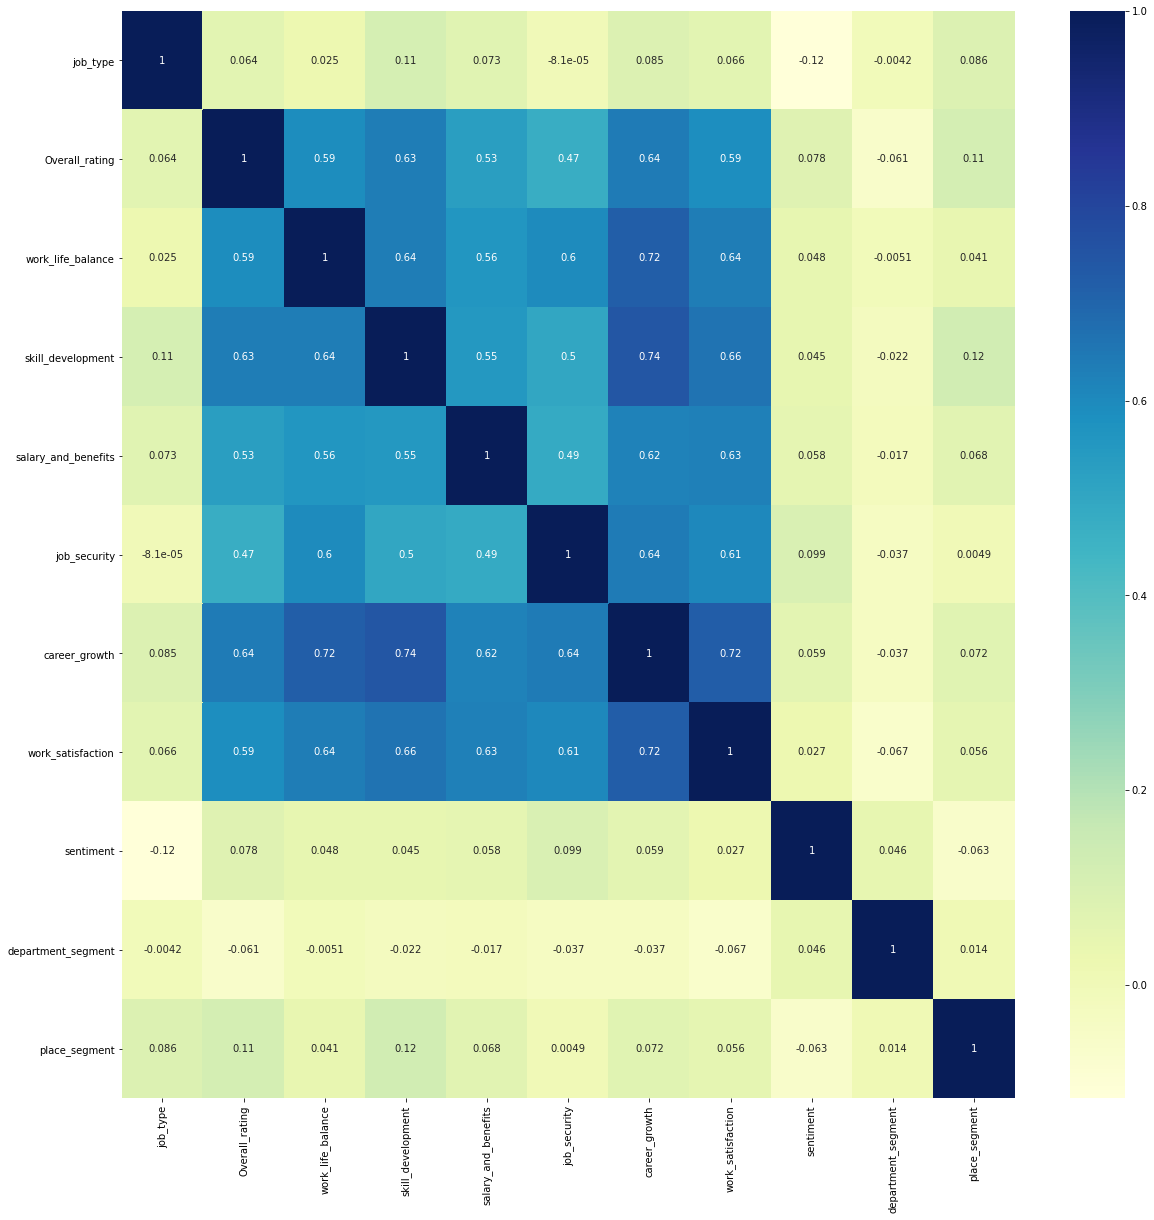

In [39]:
plt.figure(figsize=(20, 20))
sns.heatmap(df_clean_review.corr(), cmap="YlGnBu", fmt='.2g', annot=True)

In [40]:
df_clean_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1211 entries, 0 to 1210
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   job_type             1211 non-null   int32  
 1   Overall_rating       1123 non-null   float64
 2   work_life_balance    1210 non-null   float64
 3   skill_development    1210 non-null   float64
 4   salary_and_benefits  1209 non-null   float64
 5   job_security         1208 non-null   float64
 6   career_growth        1207 non-null   float64
 7   work_satisfaction    1205 non-null   float64
 8   sentiment            1211 non-null   int32  
 9   department_segment   1211 non-null   int32  
 10  place_segment        1211 non-null   int32  
dtypes: float64(7), int32(4)
memory usage: 85.3 KB


In [41]:
# Handling Missing Values: 
# Fill missing values in specific columns with the mean of each column
columns_null = ['Overall_rating', 'work_life_balance', 'skill_development', 'salary_and_benefits', 'job_security', 'career_growth', 'work_satisfaction']

for col in columns_null:
    df_clean_review[col].fillna(df_clean_review[col].mean(), inplace=True)

In [42]:
df_clean_review.head()

,job_type,Overall_rating,work_life_balance,skill_development,salary_and_benefits,job_security,career_growth,work_satisfaction,sentiment,department_segment,place_segment
0,1,3.0,3.0,1.0,3.0,3.0,2.0,2.0,2,1,3
1,1,5.0,5.0,5.0,5.0,5.0,5.0,5.0,0,3,0
2,1,4.0,4.0,4.0,4.0,4.0,4.0,4.0,2,4,0
3,1,4.0,3.0,4.0,5.0,5.0,4.0,3.0,2,6,0
4,1,4.0,2.0,3.0,3.0,3.0,3.0,4.0,2,5,3


In [43]:
# Splitting the dataset
x = df_clean_review.drop(columns = ['sentiment', 'Overall_rating'], axis=1)
y = df_clean_review['sentiment']

In [44]:
# Convert to numpy arrays
x = x.values
y = y.values

In [45]:
# Shuffle the data to ensure the overall distribution of the data 
# before split into train dan test data
z = list(zip(x, y))
random.shuffle(z)
x, y = zip(*z)
x, y = np.array(x), np.array(y)

In [46]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=0)

### Imbalanced Data Solutions: SMOTE 

In [47]:
from imblearn.over_sampling import SMOTE

# Display class distribution before SMOTE
print("Before OverSampling, counts of label '2': {}".format(sum(y_train == 2)))
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

# Apply SMOTE to balance the class distribution
sm = SMOTE()
x_train_smote, y_train_smote = sm.fit_resample(x_train, y_train.ravel())

# Display class distribution after SMOTE
print('After OverSampling, the shape of train_X: {}'.format(x_train_smote.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_smote.shape))

print("After OverSampling, counts of label '2': {}".format(sum(y_train_smote == 2)))
print("After OverSampling, counts of label '1': {}".format(sum(y_train_smote == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_smote == 0)))

Before OverSampling, counts of label '2': 523
Before OverSampling, counts of label '1': 252
Before OverSampling, counts of label '0': 72 

After OverSampling, the shape of train_X: (1569, 9)
After OverSampling, the shape of train_y: (1569,) 

After OverSampling, counts of label '2': 523
After OverSampling, counts of label '1': 523
After OverSampling, counts of label '0': 523


## Training and Testing Model Machine Learning

### Decision Tree Classifier

In [48]:
# Creating a Decision Tree Classifier
dt_classifier = DecisionTreeClassifier()

# Defining the parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8],
    'min_samples_split': [None, 1, 2, 3, 4, 5],
    'min_samples_leaf': [None, 1, 2, 3, 4],
    'random_state': [0, 42]
}

# Performing Grid Search with cross-validation
grid_search = GridSearchCV(dt_classifier, param_grid, cv=5)
grid_search.fit(x_train_smote, y_train_smote)
print(grid_search.best_params_)

{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 0}


In [113]:
# Creating a Decision Tree Classifier with the best hyperparameters
dt_classifier = DecisionTreeClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=2, random_state=0)

# Fitting the model on the SMOTE-resampled training data
dt_classifier.fit(x_train_smote, y_train_smote)

# Making predictions on the data test
y_pred = dt_classifier.predict(x_test)

# Displaying the classification report
print('Classification report: \n', classification_report(y_test, y_pred))

Classification report: 
               precision    recall  f1-score   support

           0       0.07      0.19      0.11        21
           1       0.44      0.45      0.45       117
           2       0.68      0.57      0.62       226

    accuracy                           0.51       364
   macro avg       0.40      0.40      0.39       364
weighted avg       0.57      0.51      0.53       364



Accuracy:  0.5082417582417582
F-1 Score :  0.5082417582417582
Precision Score :  0.5082417582417582
Recall Score :  0.5082417582417582


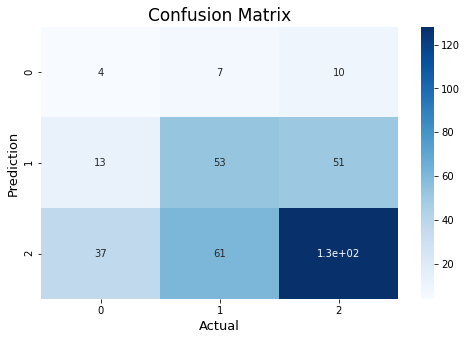

In [114]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True, cmap='Blues')
plt.ylabel('Prediction', fontsize=13)
plt.xlabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17)

# Displaying additional performance metrics
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('F-1 Score : ',(f1_score(y_test, y_pred, average='micro')))
print('Precision Score : ',(precision_score(y_test, y_pred, average='micro')))
print('Recall Score : ',(recall_score(y_test, y_pred, average='micro')))

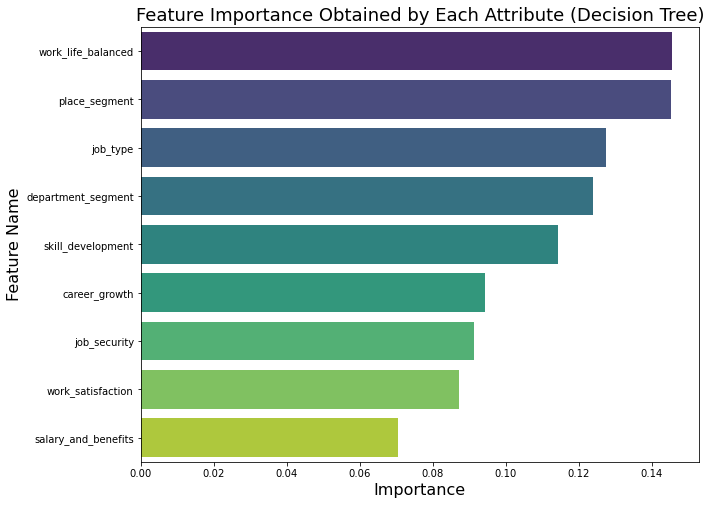

In [83]:
# Creating a DataFrame for feature importance
feature_names = ['job_type', 'work_life_balanced', 'skill_development', 'salary_and_benefits', 'job_security', 'career_growth', 'work_satisfaction', 'department_segment', 'place_segment']
feature_df = pd.DataFrame({
    'Feature Name': feature_names,
    'Importance': dt_classifier.feature_importances_
})
# Sorting features based on importance
feature_imp = feature_df.sort_values(by='Importance', ascending=False)

# Plotting a bar plot for feature importance
plt.figure(figsize=(10,8))
sns.barplot(data=feature_imp, x='Importance', y='Feature Name', palette='viridis')
plt.title('Feature Importance Obtained by Each Attribute (Decision Tree)', fontsize=18)
plt.xlabel ('Importance', fontsize=16)
plt.ylabel ('Feature Name', fontsize=16)
plt.show()

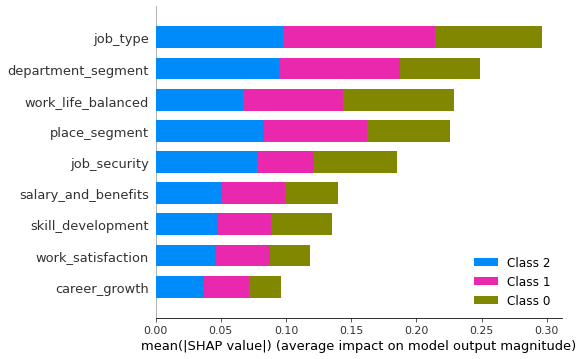

In [84]:
# Creating a DataFrame for x_test with feature names as columns
x_test_df = pd.DataFrame(x_test, columns=feature_names)

# Creating a TreeExplainer for the Decision Tree model
explainer = shap.TreeExplainer(dt_classifier)

# Generating SHAP values for x_test
shap_values = explainer.shap_values(x_test)

# Plotting a summary plot for SHAP values
shap.summary_plot(shap_values, x_test_df)

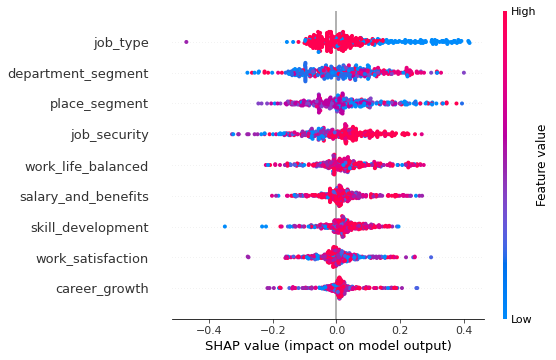

In [85]:
explainer = shap.TreeExplainer(dt_classifier)
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values[2], x_test_df, feature_names=feature_names)

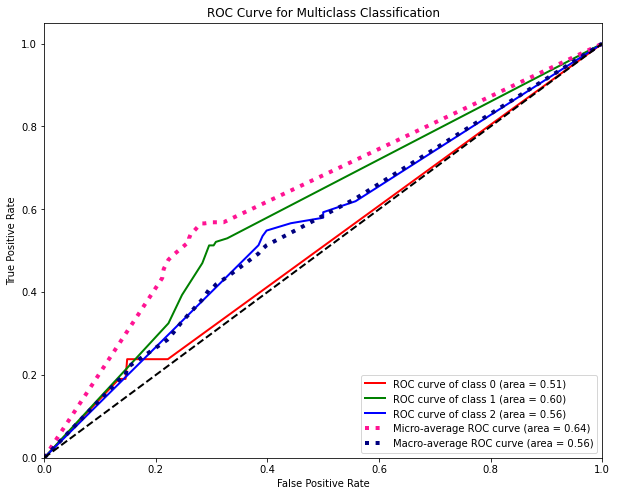

In [86]:
# Calculate the number of classes
num_classes = len(np.unique(y_test)) 

# Binarize the labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2]) 

# Fit the classifier and obtain predicted probabilities
y_score = dt_classifier.fit(x_train_smote, y_train_smote).predict_proba(x_test)

# Initialize dictionaries and arrays for ROC calculations
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and ROC area for each class
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area    
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= num_classes

fpr_macro = all_fpr
tpr_macro = mean_tpr
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Plot the ROC curve
plt.figure(figsize=(10, 8))

colors = ['red', 'green', 'blue'] 
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
                   ''.format(i, roc_auc[i]))

plt.plot(fpr_micro, tpr_micro, color='deeppink', linestyle=':', linewidth=4,
         label='Micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_micro))

plt.plot(fpr_macro, tpr_macro, color='navy', linestyle=':', linewidth=4,
         label='Macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_macro))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()

Average AUC: 0.56


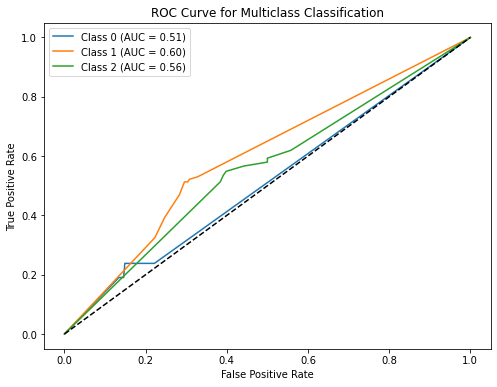

In [87]:
# Predicted probabilities for each class
y_pred_proba = dt_classifier.predict_proba(x_test)

# Binarize the labels
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Initialize dictionaries and arrays for ROC calculations
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and ROC area for each class
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calculate the average AUC    
average_auc = np.mean(list(roc_auc.values()))

# Plot the ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Print the average AUC    
print(f'Average AUC: {average_auc:.2f}')

# Plot the diagonal line
plt.plot([0, 1], [0, 1], linestyle='--', color='k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend()
plt.show()

In [88]:
# Creating a Decision Tree Classifier with default hyperparameters
dt = DecisionTreeClassifier()
dt.fit(x_train_smote, y_train_smote)
y_pred = dt.predict(x_test)
print('Classification report: \n', classification_report(y_test, y_pred))

Classification report: 
               precision    recall  f1-score   support

           0       0.06      0.14      0.08        21
           1       0.45      0.46      0.45       117
           2       0.67      0.56      0.61       226

    accuracy                           0.50       364
   macro avg       0.39      0.39      0.38       364
weighted avg       0.56      0.50      0.53       364



Accuracy:  0.5027472527472527
F-1:  0.5027472527472527
Precision:  0.5027472527472527
Recall:  0.5027472527472527


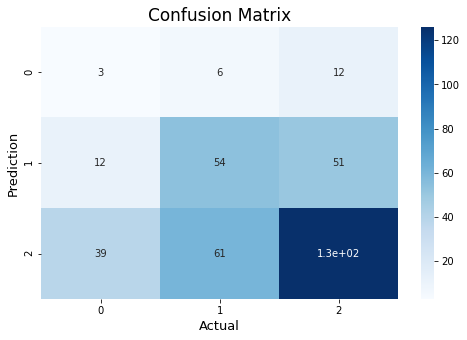

In [89]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True, cmap='Blues')
plt.ylabel('Prediction', fontsize=13)
plt.xlabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17)

# Displaying additional performance metrics
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('F-1: ',(f1_score(y_test, y_pred, average='micro')))
print('Precision: ',(precision_score(y_test, y_pred, average='micro')))
print('Recall: ',(recall_score(y_test, y_pred, average='micro')))

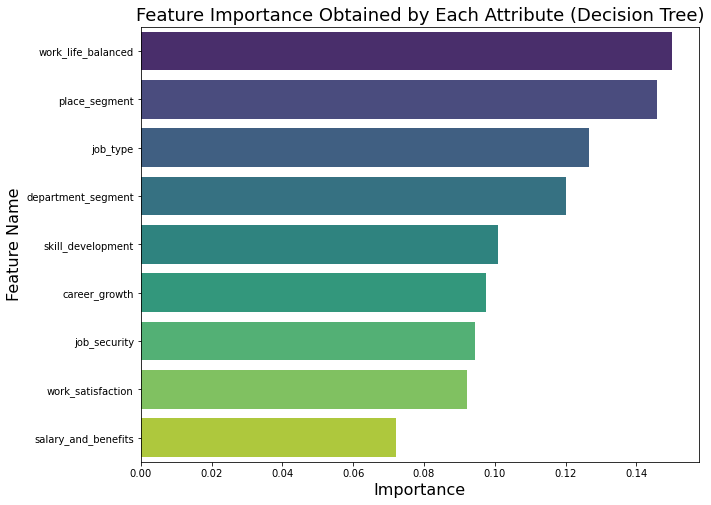

In [90]:
# Creating a DataFrame for feature importance
feature_names = ['job_type', 'work_life_balanced', 'skill_development', 'salary_and_benefits', 'job_security', 'career_growth', 'work_satisfaction', 'department_segment', 'place_segment']
feature_df = pd.DataFrame({
    'Feature Name': feature_names,
    'Importance': dt.feature_importances_
})
# Sorting features based on importance
feature_imp = feature_df.sort_values(by='Importance', ascending=False)

# Plotting a bar plot for feature importance
plt.figure(figsize=(10,8))
sns.barplot(data=feature_imp, x='Importance', y='Feature Name', palette='viridis')
plt.title('Feature Importance Obtained by Each Attribute (Decision Tree)', fontsize=18)
plt.xlabel ('Importance', fontsize=16)
plt.ylabel ('Feature Name', fontsize=16)
plt.show()

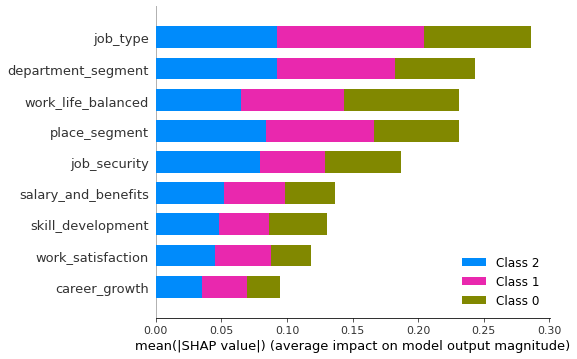

In [91]:
# Creating a DataFrame for x_test with feature names as columns
x_test_df = pd.DataFrame(x_test, columns=feature_names)

# Creating a TreeExplainer for the Decision Tree model
explainer = shap.TreeExplainer(dt)

# Generating SHAP values for x_test
shap_values = explainer.shap_values(x_test)

# Plotting a summary plot for SHAP values
shap.summary_plot(shap_values, x_test_df)

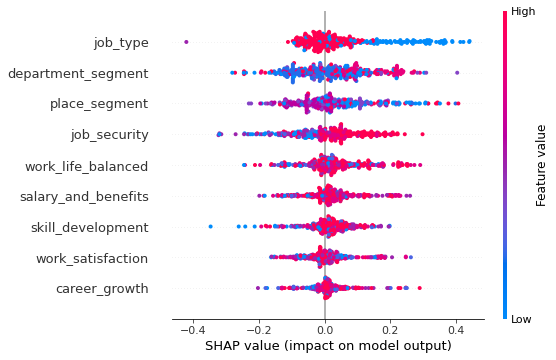

In [92]:
explainer = shap.TreeExplainer(dt)
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values[2], x_test_df, feature_names=feature_names)

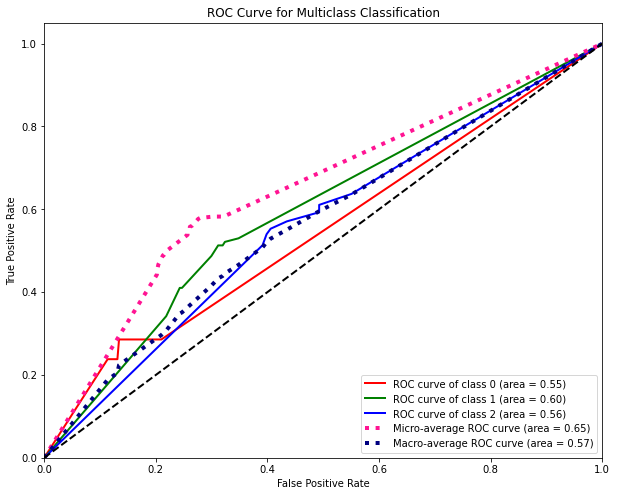

In [93]:
# Calculate the number of classes
num_classes = len(np.unique(y_test)) 

# Binarize the labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

# Fit the classifier and obtain predicted probabilities
y_score = dt.fit(x_train_smote, y_train_smote).predict_proba(x_test)

# Initialize dictionaries and arrays for ROC calculations
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and ROC area for each class
for i in range(num_classes):  
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= num_classes

fpr_macro = all_fpr
tpr_macro = mean_tpr
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Plot the ROC curve
plt.figure(figsize=(10, 8))

colors = ['red', 'green', 'blue']
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
                   ''.format(i, roc_auc[i]))

plt.plot(fpr_micro, tpr_micro, color='deeppink', linestyle=':', linewidth=4,
         label='Micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_micro))

plt.plot(fpr_macro, tpr_macro, color='navy', linestyle=':', linewidth=4,
         label='Macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_macro))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()

Average AUC: 0.57


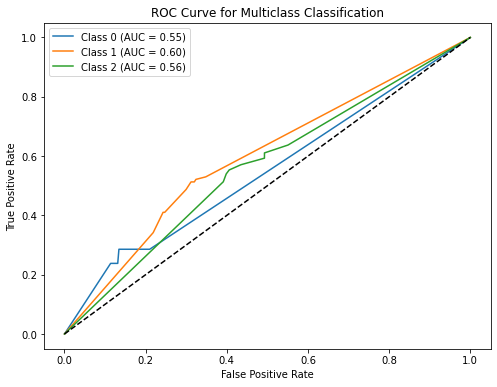

In [94]:
# Predicted probabilities for each class
y_pred_proba = dt.predict_proba(x_test)

# Binarize the labels
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Initialize dictionaries and arrays for ROC calculations
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and ROC area for each class
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calculate the average AUC    
average_auc = np.mean(list(roc_auc.values()))

# Plot the ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Print the average AUC    
print(f'Average AUC: {average_auc:.2f}')

# Plot the diagonal line
plt.plot([0, 1], [0, 1], linestyle='--', color='k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend()
plt.show()

### Random Forest

In [95]:
rf = RandomForestClassifier()
rf.fit(x_train_smote, y_train_smote)
y_pred = rf.predict(x_test)
print('Classification report: \n', classification_report(y_test, y_pred))

Classification report: 
               precision    recall  f1-score   support

           0       0.13      0.14      0.14        21
           1       0.49      0.42      0.45       117
           2       0.69      0.73      0.71       226

    accuracy                           0.60       364
   macro avg       0.43      0.43      0.43       364
weighted avg       0.59      0.60      0.59       364



Accuracy:  0.5961538461538461
F-1:  0.5961538461538461
Precision:  0.5961538461538461
Recall:  0.5961538461538461


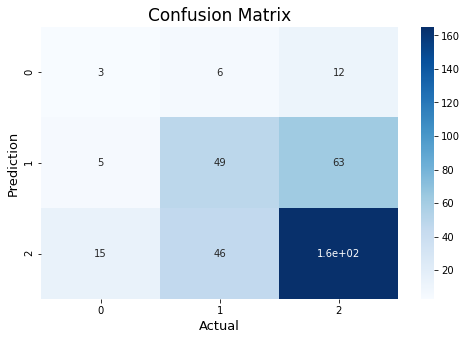

In [96]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True, cmap='Blues')
plt.ylabel('Prediction', fontsize=13)
plt.xlabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17)

print('Accuracy: ',accuracy_score(y_test, y_pred))
print('F-1: ',(f1_score(y_test, y_pred, average='micro')))
print('Precision: ',(precision_score(y_test, y_pred, average='micro')))
print('Recall: ',(recall_score(y_test, y_pred, average='micro')))

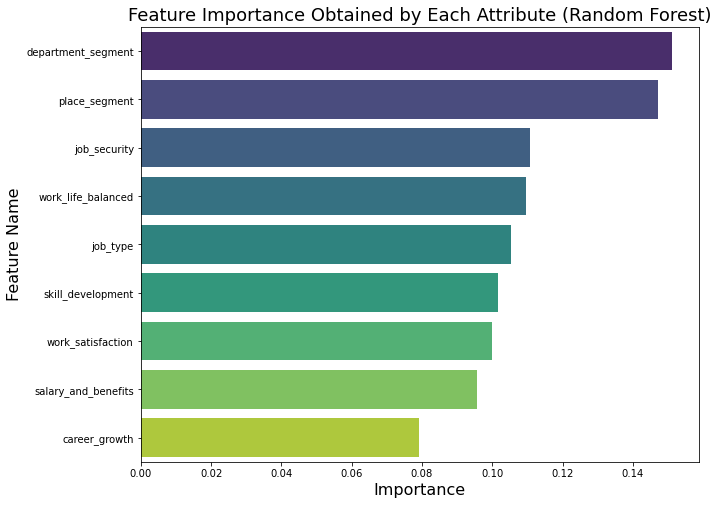

In [97]:
# Creating a DataFrame for feature importance
feature_names = ['job_type', 'work_life_balanced', 'skill_development', 'salary_and_benefits', 'job_security', 'career_growth', 'work_satisfaction', 'department_segment', 'place_segment']
feature_df = pd.DataFrame({
    'Feature Name': feature_names,
    'Importance': rf.feature_importances_
})
# Sorting features based on importance
feature_imp = feature_df.sort_values(by='Importance', ascending=False)

# Plotting a bar plot for feature importance
plt.figure(figsize=(10,8))
sns.barplot(data=feature_imp, x='Importance', y='Feature Name', palette='viridis')
plt.title('Feature Importance Obtained by Each Attribute (Random Forest)', fontsize=18)
plt.xlabel ('Importance', fontsize=16)
plt.ylabel ('Feature Name', fontsize=16)
plt.show()

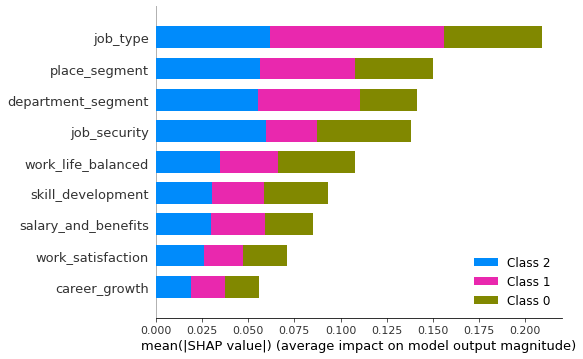

In [98]:
# Creating a DataFrame for x_test with feature names as columns
x_test_df = pd.DataFrame(x_test, columns=feature_names)

# Creating a TreeExplainer for the Random Forest Classifier model
explainer = shap.TreeExplainer(rf)

# Generating SHAP values for x_test
shap_values = explainer.shap_values(x_test)

# Plotting a summary plot for SHAP values
shap.summary_plot(shap_values, x_test_df)

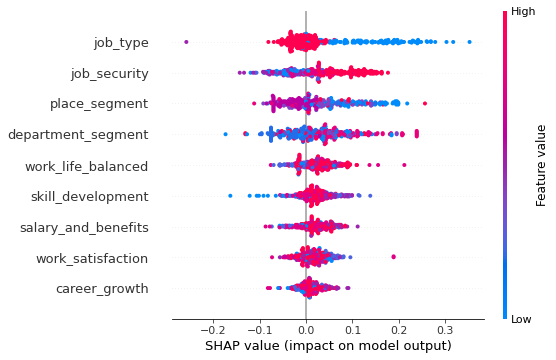

In [99]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values[2], x_test_df, feature_names=feature_names)

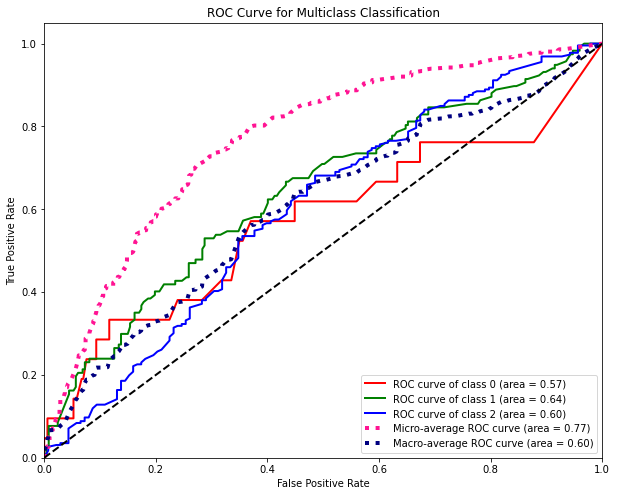

In [100]:
# Calculate the number of classes
num_classes = len(np.unique(y_test)) 

# Binarize the labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

# Fit the classifier and obtain predicted probabilities
y_score = rf.fit(x_train_smote, y_train_smote).predict_proba(x_test)

# Initialize dictionaries and arrays for ROC calculations
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and ROC area for each class
for i in range(num_classes):  
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= num_classes

fpr_macro = all_fpr
tpr_macro = mean_tpr
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Plot the ROC curve
plt.figure(figsize=(10, 8))

colors = ['red', 'green', 'blue']
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
                   ''.format(i, roc_auc[i]))

plt.plot(fpr_micro, tpr_micro, color='deeppink', linestyle=':', linewidth=4,
         label='Micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_micro))

plt.plot(fpr_macro, tpr_macro, color='navy', linestyle=':', linewidth=4,
         label='Macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_macro))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()

Average AUC: 0.60


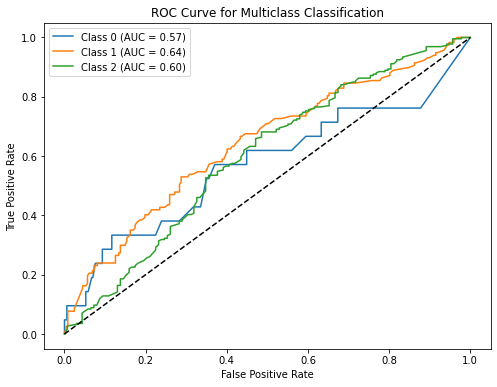

In [101]:
# Predicted probabilities for each class
y_pred_proba = rf.predict_proba(x_test)

# Binarize the labels
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Initialize dictionaries and arrays for ROC calculations
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and ROC area for each class
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calculate the average AUC    
average_auc = np.mean(list(roc_auc.values()))

# Plot the ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Print the average AUC    
print(f'Average AUC: {average_auc:.2f}')

# Plot the diagonal line
plt.plot([0, 1], [0, 1], linestyle='--', color='k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend()
plt.show()

### SVM

In [102]:
svm = SVC(probability=True, kernel='linear', decision_function_shape='ovr')
svm.fit(x_train_smote, y_train_smote)
y_pred = svm.predict(x_test)
print('Classification report: \n', classification_report(y_test, y_pred))

Classification report: 
               precision    recall  f1-score   support

           0       0.07      0.29      0.11        21
           1       0.42      0.74      0.53       117
           2       0.81      0.26      0.39       226

    accuracy                           0.41       364
   macro avg       0.43      0.43      0.35       364
weighted avg       0.64      0.41      0.42       364



Accuracy:  0.41483516483516486
F-1:  0.41483516483516486
Precision:  0.41483516483516486
Recall:  0.41483516483516486


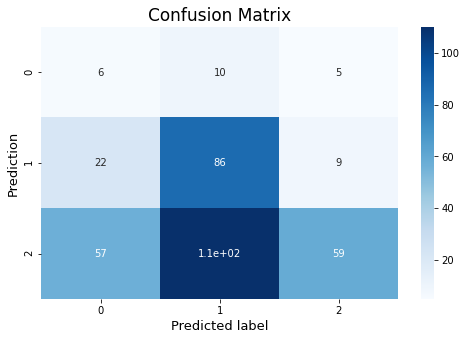

In [103]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True, cmap='Blues')
plt.ylabel('Prediction', fontsize=13)
plt.xlabel('Predicted label', fontsize=13)
plt.title('Confusion Matrix', size=17)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('F-1: ',(f1_score(y_test, y_pred, average='micro')))
print('Precision: ',(precision_score(y_test, y_pred, average='micro')))
print('Recall: ',(recall_score(y_test, y_pred, average='micro')))

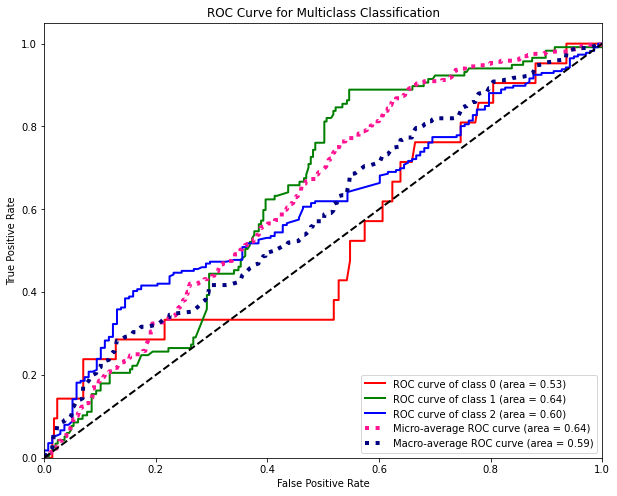

In [104]:
# Calculate the number of classes
num_classes = len(np.unique(y_test)) 

# Binarize the labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

# Fit the classifier and obtain predicted probabilities
y_score = svm.fit(x_train_smote, y_train_smote).predict_proba(x_test)

# Initialize dictionaries and arrays for ROC calculations
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and ROC area for each class
for i in range(num_classes):  
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= num_classes

fpr_macro = all_fpr
tpr_macro = mean_tpr
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Plot the ROC curve
plt.figure(figsize=(10, 8))

colors = ['red', 'green', 'blue']
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
                   ''.format(i, roc_auc[i]))

plt.plot(fpr_micro, tpr_micro, color='deeppink', linestyle=':', linewidth=4,
         label='Micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_micro))

plt.plot(fpr_macro, tpr_macro, color='navy', linestyle=':', linewidth=4,
         label='Macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_macro))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()

Average AUC: 0.59


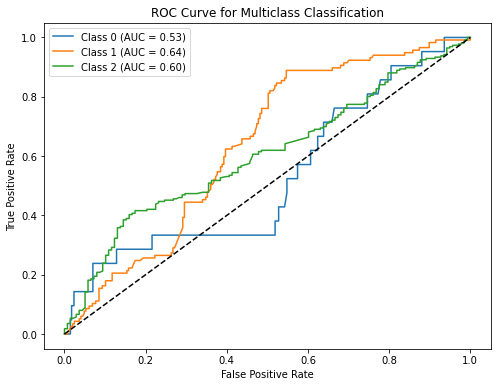

In [105]:
# Predicted probabilities for each class
y_pred_proba = svm.predict_proba(x_test)

# Binarize the labels
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Initialize dictionaries and arrays for ROC calculations
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and ROC area for each class
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calculate the average AUC    
average_auc = np.mean(list(roc_auc.values()))

# Plot the ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Print the average AUC    
print(f'Average AUC: {average_auc:.2f}')

# Plot the diagonal line
plt.plot([0, 1], [0, 1], linestyle='--', color='k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend()
plt.show()

### XGBoost

In [106]:
xgboost = xgb.XGBClassifier()
xgboost.fit(x_train_smote, y_train_smote)
y_pred = xgboost.predict(x_test)
print('Classification report: \n', classification_report(y_test, y_pred))

Classification report: 
               precision    recall  f1-score   support

           0       0.04      0.05      0.04        21
           1       0.48      0.39      0.43       117
           2       0.66      0.70      0.68       226

    accuracy                           0.57       364
   macro avg       0.39      0.38      0.39       364
weighted avg       0.57      0.57      0.56       364



Accuracy:  0.5659340659340659
F-1:  0.5659340659340659
Precision:  0.5659340659340659
Recall:  0.5659340659340659


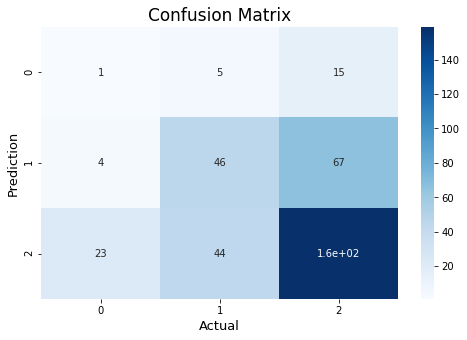

In [107]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True, cmap='Blues')
plt.ylabel('Prediction', fontsize=13)
plt.xlabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17)

print('Accuracy: ',accuracy_score(y_test, y_pred))
print('F-1: ',(f1_score(y_test, y_pred, average='micro')))
print('Precision: ',(precision_score(y_test, y_pred, average='micro')))
print('Recall: ',(recall_score(y_test, y_pred, average='micro')))

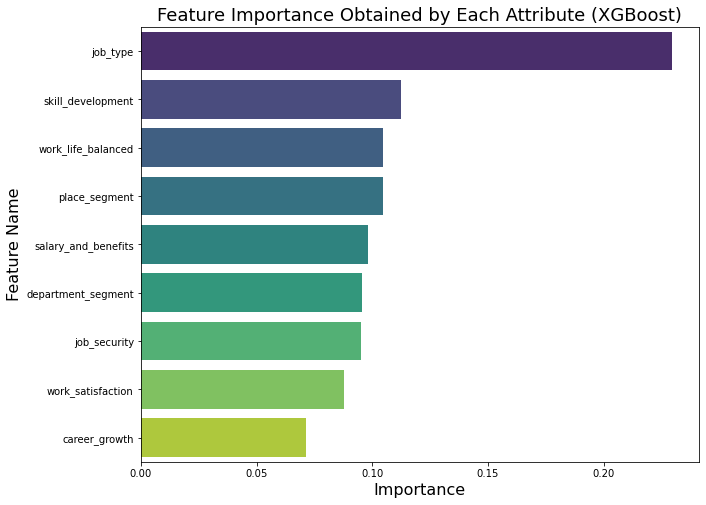

In [108]:
# Creating a DataFrame for feature importance
feature_names = ['job_type', 'work_life_balanced', 'skill_development', 'salary_and_benefits', 'job_security', 'career_growth', 'work_satisfaction', 'department_segment', 'place_segment']
feature_df = pd.DataFrame({
    'Feature Name': feature_names,
    'Importance': xgboost.feature_importances_
})
# Sorting features based on importance
feature_imp = feature_df.sort_values(by='Importance', ascending=False)

# Plotting a bar plot for feature importance
plt.figure(figsize=(10,8))
sns.barplot(data=feature_imp, x='Importance', y='Feature Name', palette='viridis')
plt.title('Feature Importance Obtained by Each Attribute (XGBoost)', fontsize=18)
plt.xlabel ('Importance', fontsize=16)
plt.ylabel ('Feature Name', fontsize=16)
plt.show()

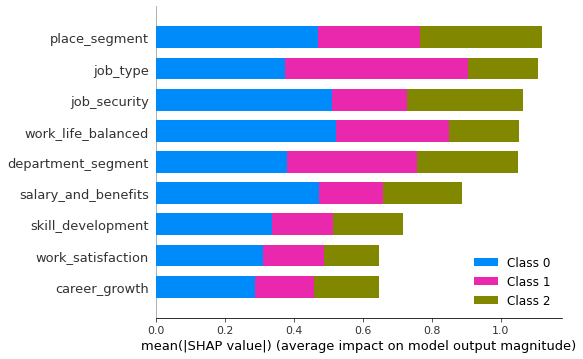

In [109]:
# Creating a DataFrame for x_test with feature names as columns
x_test_df = pd.DataFrame(x_test, columns=feature_names)

# Creating a TreeExplainer for the XGBoost Classifier model
explainer = shap.TreeExplainer(xgboost)

# Generating SHAP values for x_test
shap_values = explainer.shap_values(x_test)

# Plotting a summary plot for SHAP values
shap.summary_plot(shap_values, x_test_df)

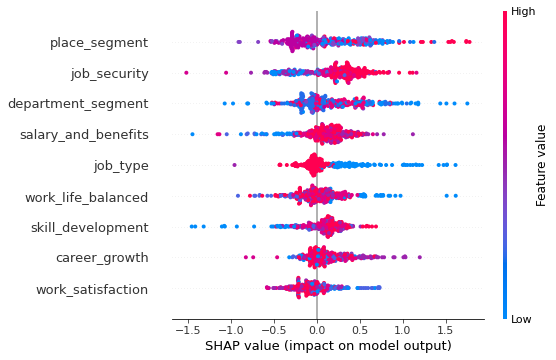

In [110]:
explainer = shap.TreeExplainer(xgboost)
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values[2], x_test_df, feature_names=feature_names)

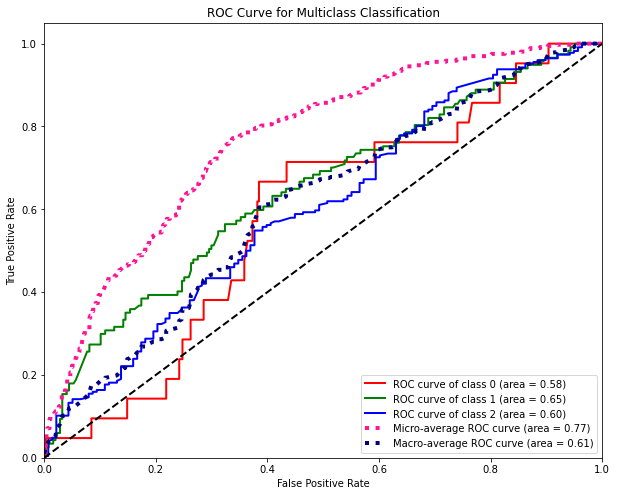

In [111]:
# Calculate the number of classes
num_classes = len(np.unique(y_test)) 

# Binarize the labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

# Fit the classifier and obtain predicted probabilities
y_score = xgboost.fit(x_train_smote, y_train_smote).predict_proba(x_test)

# Initialize dictionaries and arrays for ROC calculations
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and ROC area for each class
for i in range(num_classes):  
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= num_classes

fpr_macro = all_fpr
tpr_macro = mean_tpr
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Plot the ROC curve
plt.figure(figsize=(10, 8))

colors = ['red', 'green', 'blue']
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
                   ''.format(i, roc_auc[i]))

plt.plot(fpr_micro, tpr_micro, color='deeppink', linestyle=':', linewidth=4,
         label='Micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_micro))

plt.plot(fpr_macro, tpr_macro, color='navy', linestyle=':', linewidth=4,
         label='Macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_macro))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()

Average AUC: 0.61


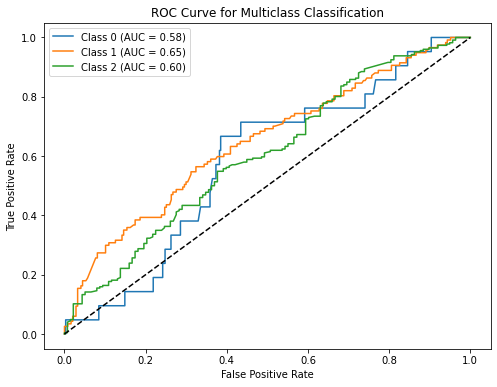

In [112]:
# Predicted probabilities for each class
y_pred_proba = xgboost.predict_proba(x_test)

# Binarize the labels
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Initialize dictionaries and arrays for ROC calculations
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and ROC area for each class
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calculate the average AUC    
average_auc = np.mean(list(roc_auc.values()))

# Plot the ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Print the average AUC    
print(f'Average AUC: {average_auc:.2f}')

# Plot the diagonal line
plt.plot([0, 1], [0, 1], linestyle='--', color='k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend()
plt.show()

The Decision Tree, after hyperparameter tuning, achieves an accuracy of 51%, while its default version gives 50%. Random Forest shows the highest performance with an accuracy of 60%, whereas SVM performs lower with only 41%. XGBoost obtains an accuracy of 57%.

Looking at the confusion matrix, the Decision Tree, Random Forest, and XGBoost models tend to predict positive and neutral sentiments well, but there are also a considerable number of false positives and false negatives.

In terms of feature importances, attributes like work_life_balanced, place_segment, and job_type consistently play a decisive role in all models, indicating the importance of these aspects in influencing employee sentiments.

SHAP Plot analysis depicts that almost all models (except SVM) have a similar pattern, especially regarding attributes job_type and job_security. However, SVM, being a complex model, is challenging to interpret through this method.

Examining the ROC Curve, the Decision Tree model shows good performance for all three classes, while the other models exhibit some difficulty in distinguishing negative sentiments.

The observed subpar performance of the models can be attributed to several factors. One of them is that the distribution of values in the features tends to be limited to the range of 1 to 5, which can reduce the complexity and variability in the data. There is also an issue of class imbalance that might affect the models, especially if one class is dominant compared to others.

Future strategies:
1. Focus on improving the representation of minority classes for models that still struggle to predict those classes.
2. Reevaluate SVM parameters or consider another model to enhance performance.
3. Further explore patterns seen in the SHAP plots to gain deeper insights.
4. Fine-tune the models and consider using ensemble methods to improve accuracy and model generalization.
5. Consider normalizing or scaling features to a broader range like 0-1 to help the model capture more variability.
6. Data expansion, if possible, by adding variations to the data through sampling or generating synthetics, can assist the model in seeing more diverse cases.